# Проект: Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

**Цель проекта: на основе производственных данных разработать модель для задачи регрессии определения конечной температуры сплава после всех этапов обработки материала**

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:

* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
pip install -r requirements.txt 

  Using cached seaborn-0.12.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached pyod-1.1.0-py3-none-any.whl
  Using cached xgboost-2.0.3-py3-none-win_amd64.whl.metadata (2.0 kB)
Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl (10.6 MB)
Using cached xgboost-2.0.3-py3-none-win_amd64.whl (99.8 MB)

   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
   ---------------------------------------- 0/4 [xgboost]
  Attempting uninstall: scikit-learn
   

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from pyod.models.knn import KNN
from sklearn.ensemble import IsolationForest
from xgboost import XGBRegressor
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    make_scorer
)

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

import missingno as msno
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import re

In [7]:
RANDOM_STATE = 100325
PATH = 'datasets/' 
TEST_SIZE = 0.25


## Подготовка данных

###  Загрузка данных

In [8]:
try:
    data_arc = pd.read_csv(PATH + 'data_arc_new.csv', parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
    data_bulk = pd.read_csv(PATH + 'data_bulk_new.csv')
    data_bulk_time = pd.read_csv(PATH + 'data_bulk_time_new.csv', parse_dates=[i for i in range(1, 16)])
    data_gas = pd.read_csv(PATH + 'data_gas_new.csv')
    data_temp = pd.read_csv(PATH + 'data_temp_new.csv', parse_dates=['Время замера'])
    data_wire = pd.read_csv(PATH + 'data_wire_new.csv')
    data_wire_time = pd.read_csv(PATH + 'data_wire_time_new.csv', parse_dates=[i for i in range(1, 10)])

except FileNotFoundError:
    print('Wrong path name!')

In [9]:
data_names_dict = {"data_arc": data_arc, 
                   "data_bulk": data_bulk,
                   "data_bulk_time": data_bulk_time, 
                   "data_gas": data_gas, 
                   "data_temp": data_temp, 
                   "data_wire": data_wire, 
                   "data_wire_time": data_wire_time
                  }

In [10]:
for key in data_names_dict:
    print(key)
    print(list(data_names_dict[key].columns), '\n')

data_arc
['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность'] 

data_bulk
['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'] 

data_bulk_time
['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'] 

data_gas
['key', 'Газ 1'] 

data_temp
['key', 'Время замера', 'Температура'] 

data_wire
['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'] 

data_wire_time
['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'] 



**Отредактируем названия колонок с признаками, заменив пробелы на нижние подчеркивания, приведя к нижнему регистру и заменив русские названия на английские аналоги**

In [11]:
data_names_dict['data_arc'].columns = ['key', 'heat_start', 'heat_end', 'active_p', 'reactive_p']
data_names_dict['data_temp'].columns = ['key', 'measure_time', 'temperature']
data_names_dict['data_gas'].columns = ['key', 'gas_1']

In [12]:
for key in data_names_dict:
    data_names_dict[key].columns = [re.sub(r' ', '_', col).lower() for col in data_names_dict[key].columns]
    print(key)
    print(list(data_names_dict[key].columns), '\n')

data_arc
['key', 'heat_start', 'heat_end', 'active_p', 'reactive_p'] 

data_bulk
['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'] 

data_bulk_time
['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'] 

data_gas
['key', 'gas_1'] 

data_temp
['key', 'measure_time', 'temperature'] 

data_wire
['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'] 

data_wire_time
['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'] 



**Напишем функцию для первичного исследовательского анализа наших наборов данных**

In [13]:
def details(df):
    display(df.head())
    display(df.info()) 
    display(df.describe())
    print('Явных дубликатов:', df.duplicated().sum())
    print('Количество партий:', df.nunique()['key'])
    plt.figure(figsize=(6, 4))
    plt.title('Гистограмма не пропущенных значений', fontsize=20)
    msno.bar(df)

### Первичный осмотр данных

#### data_arc

,key,heat_start,heat_end,active_p,reactive_p
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         14876 non-null  int64         
 1   heat_start  14876 non-null  datetime64[ns]
 2   heat_end    14876 non-null  datetime64[ns]
 3   active_p    14876 non-null  float64       
 4   reactive_p  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,heat_start,heat_end,active_p,reactive_p
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Явных дубликатов: 0
Количество партий: 3214


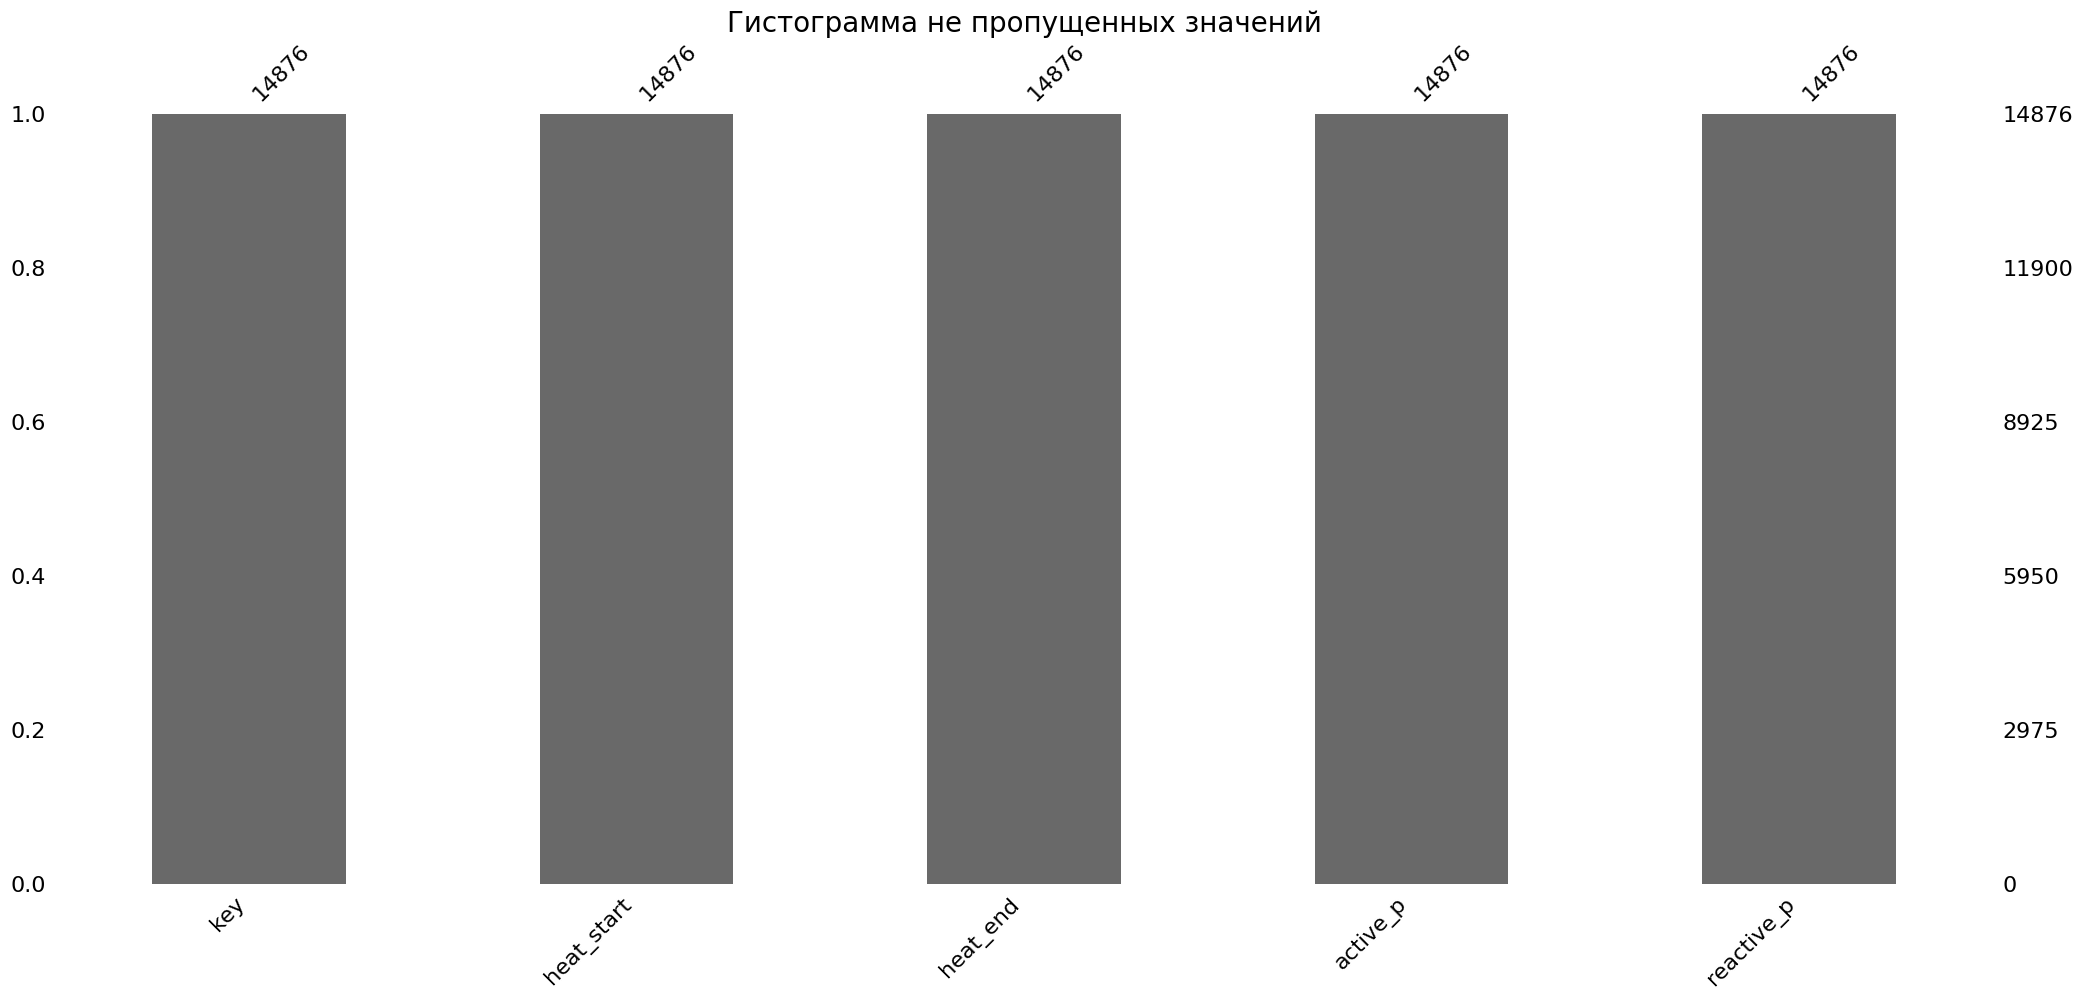

In [14]:
details(data_arc)

**В данных об электродах нет пропущенных значений, дубликатов и все колонки приведены к корректному типу данных. Всего в датафрейме 14876 вхождений и 3214 уникальных партий. По поводу выбросов можно сразу отметить аномально большое по модулю отрицательное значение наименьшей реактивной мощности.**

#### data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Явных дубликатов: 0
Количество партий: 3129


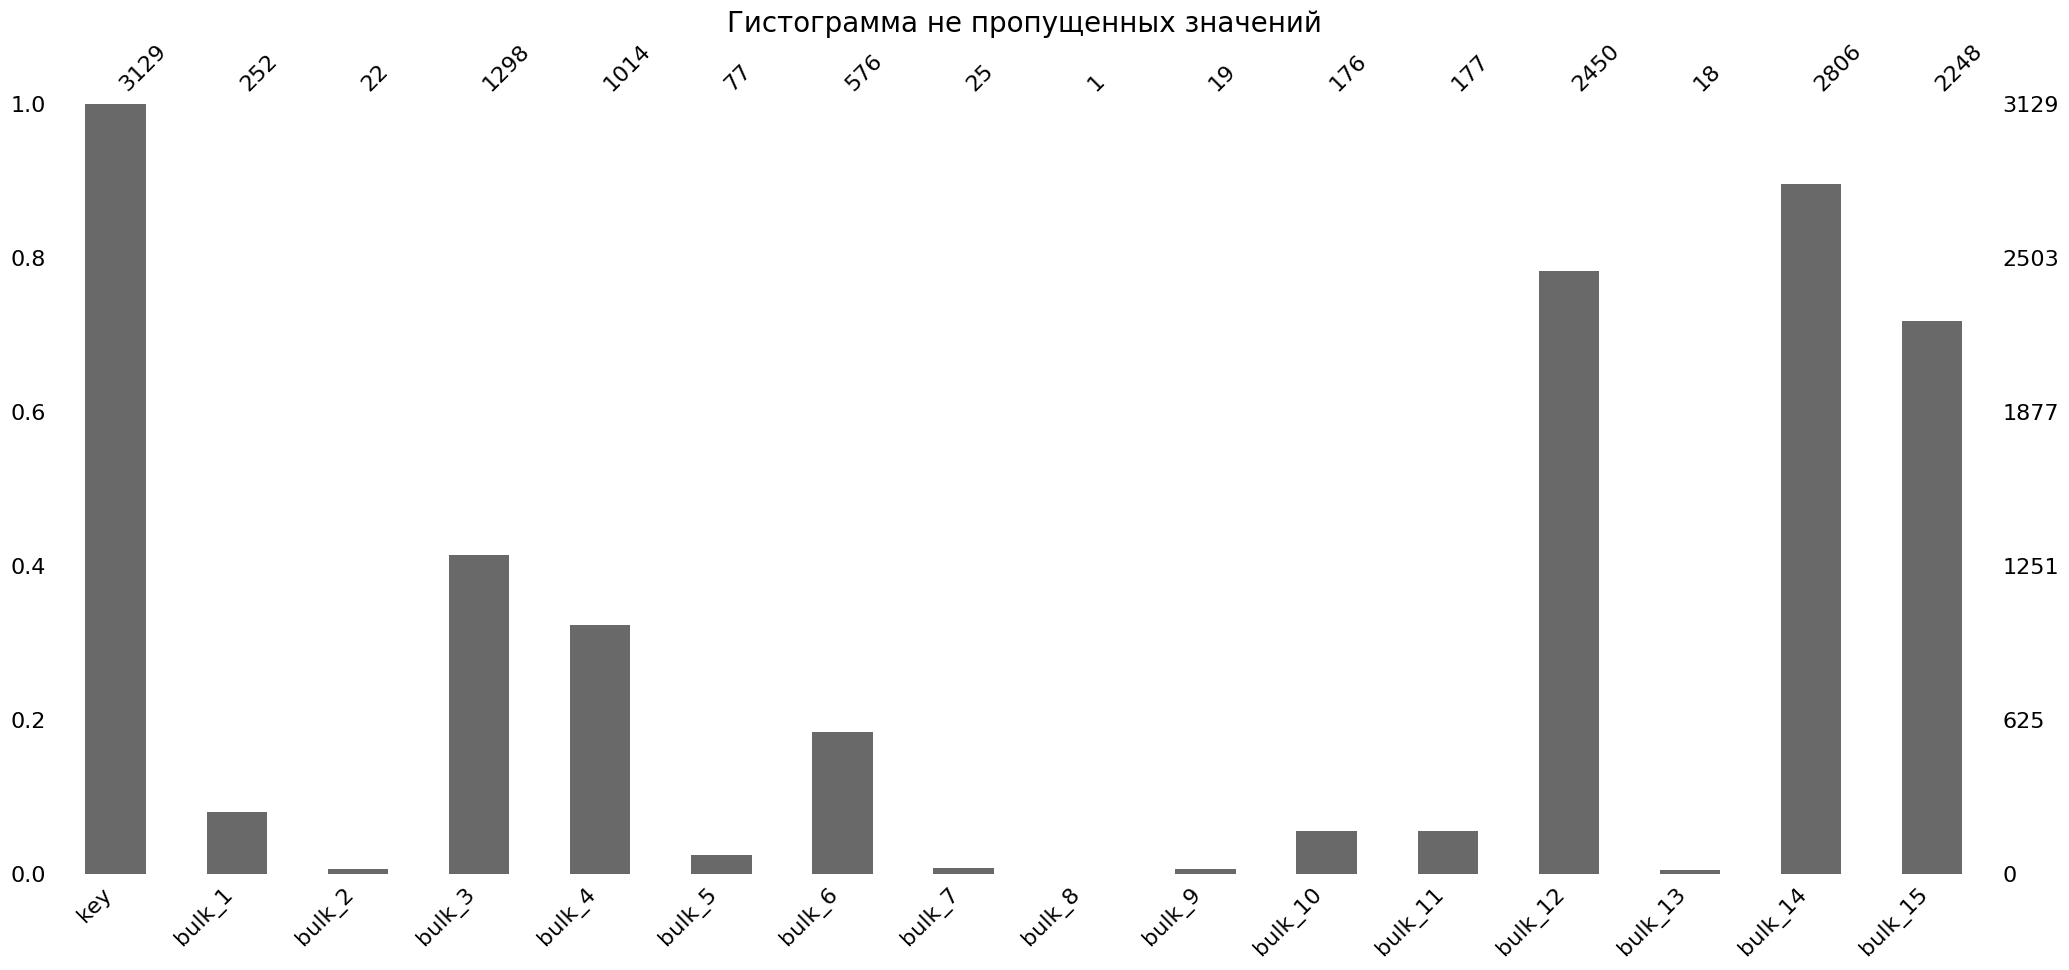

In [15]:
details(data_bulk)

**В данных о подаче сыпучих материалов 3129 уникальных партии, много пропущенных значений с которыми мы будем работать далее, например материал bulk_8 был использован только в 1(!) партии, очевидно, что для модели подобные признаки не представляют ценности. Чаще других добавляют 12, 14 и 15 материалы. Формат всех признаков корректный, дубликатов нет**

#### data_bulk_time

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


None

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Явных дубликатов: 0
Количество партий: 3129


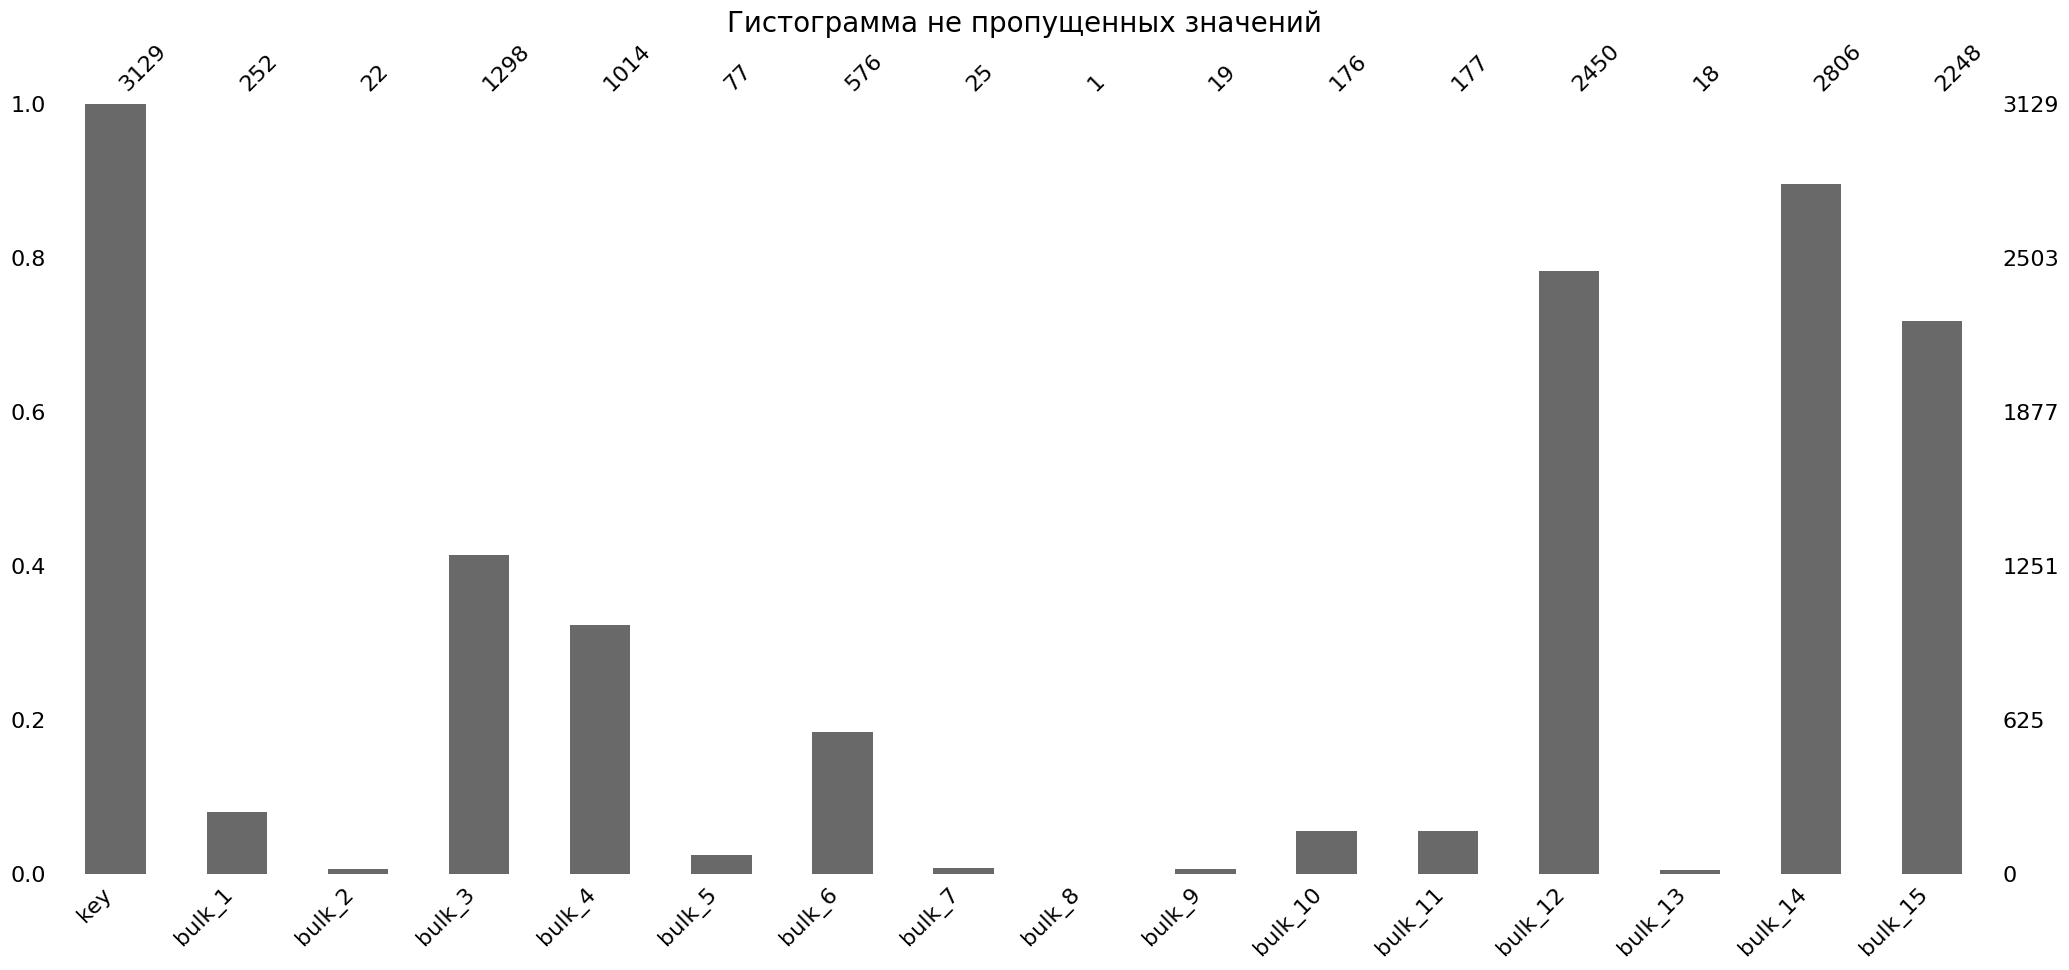

In [16]:
details(data_bulk_time)

**То же самое, как и в предыдущем датасете, мало данных по некоторым сыпучим материалам**

#### data_gas

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Явных дубликатов: 0
Количество партий: 3239


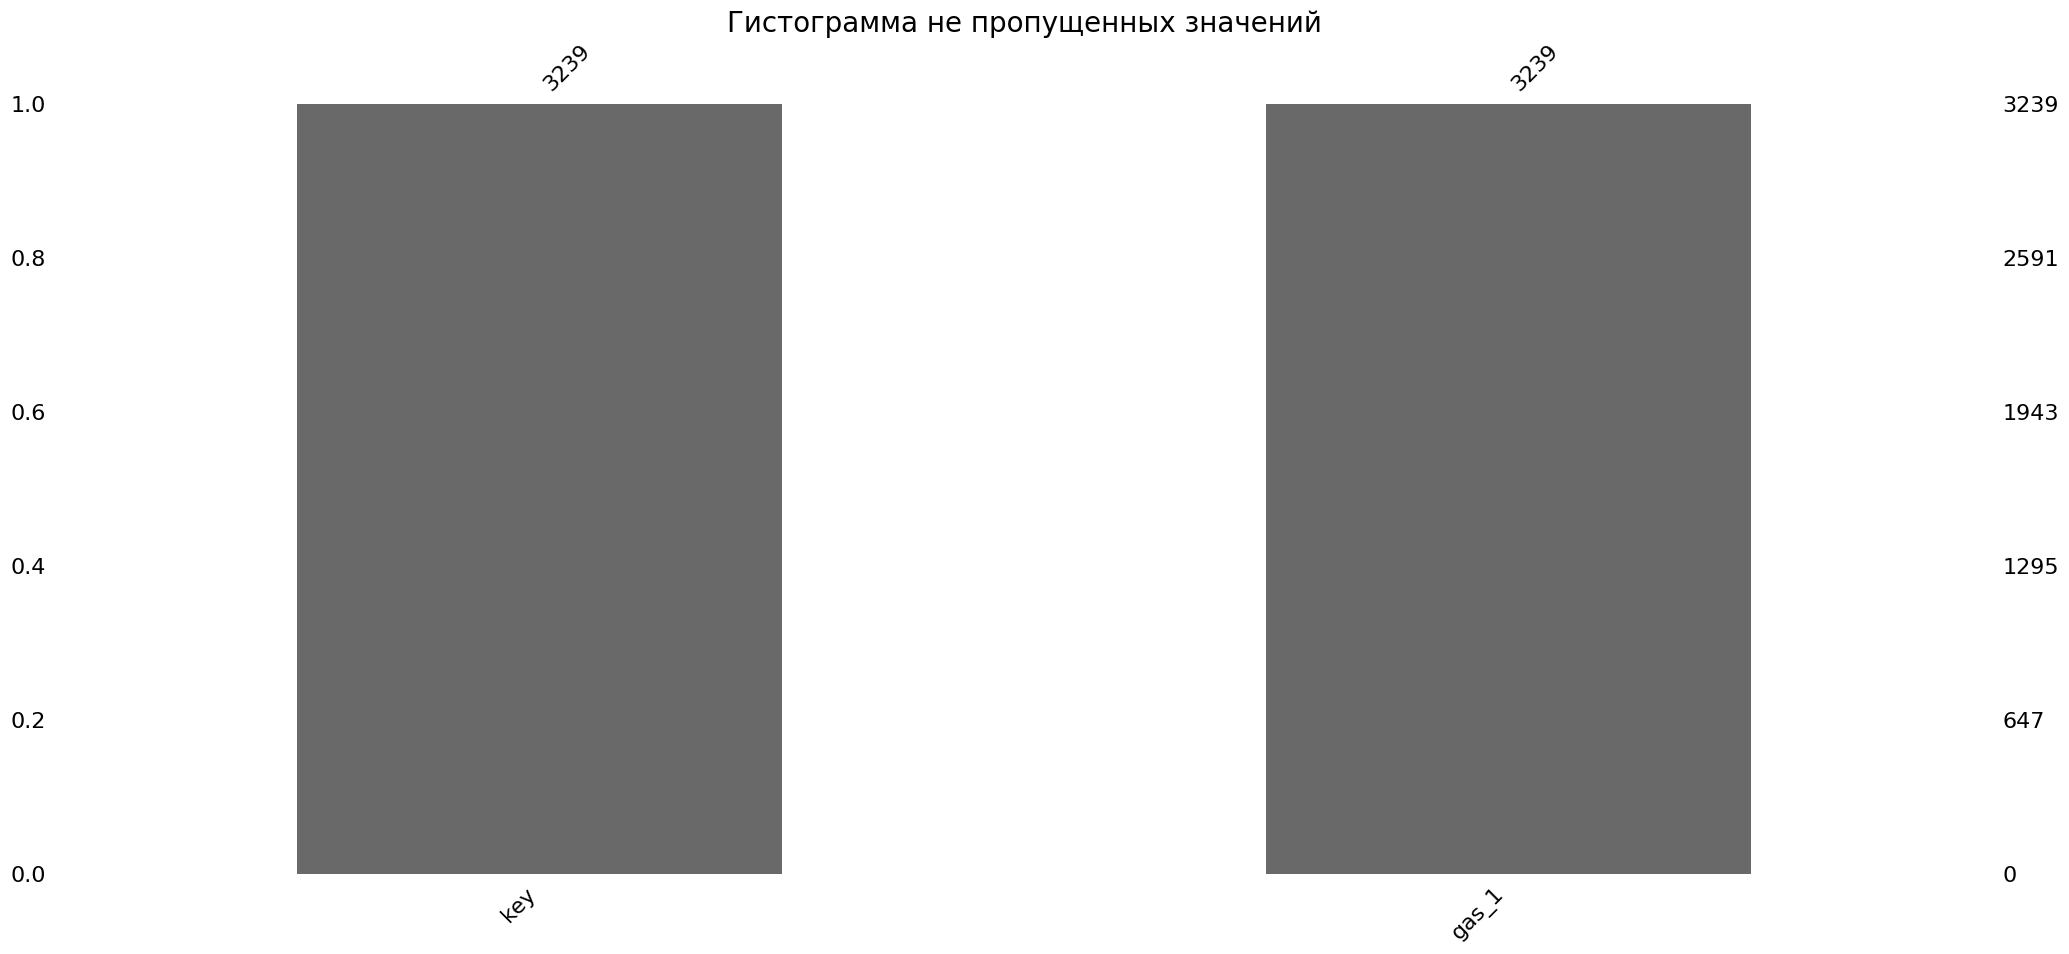

In [17]:
details(data_gas)

**Пропущенных значений нет, количество партий 3239, больше, чем в bulk-датасетах**

#### data_temp

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   measure_time  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,measure_time,temperature
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


Явных дубликатов: 0
Количество партий: 3216


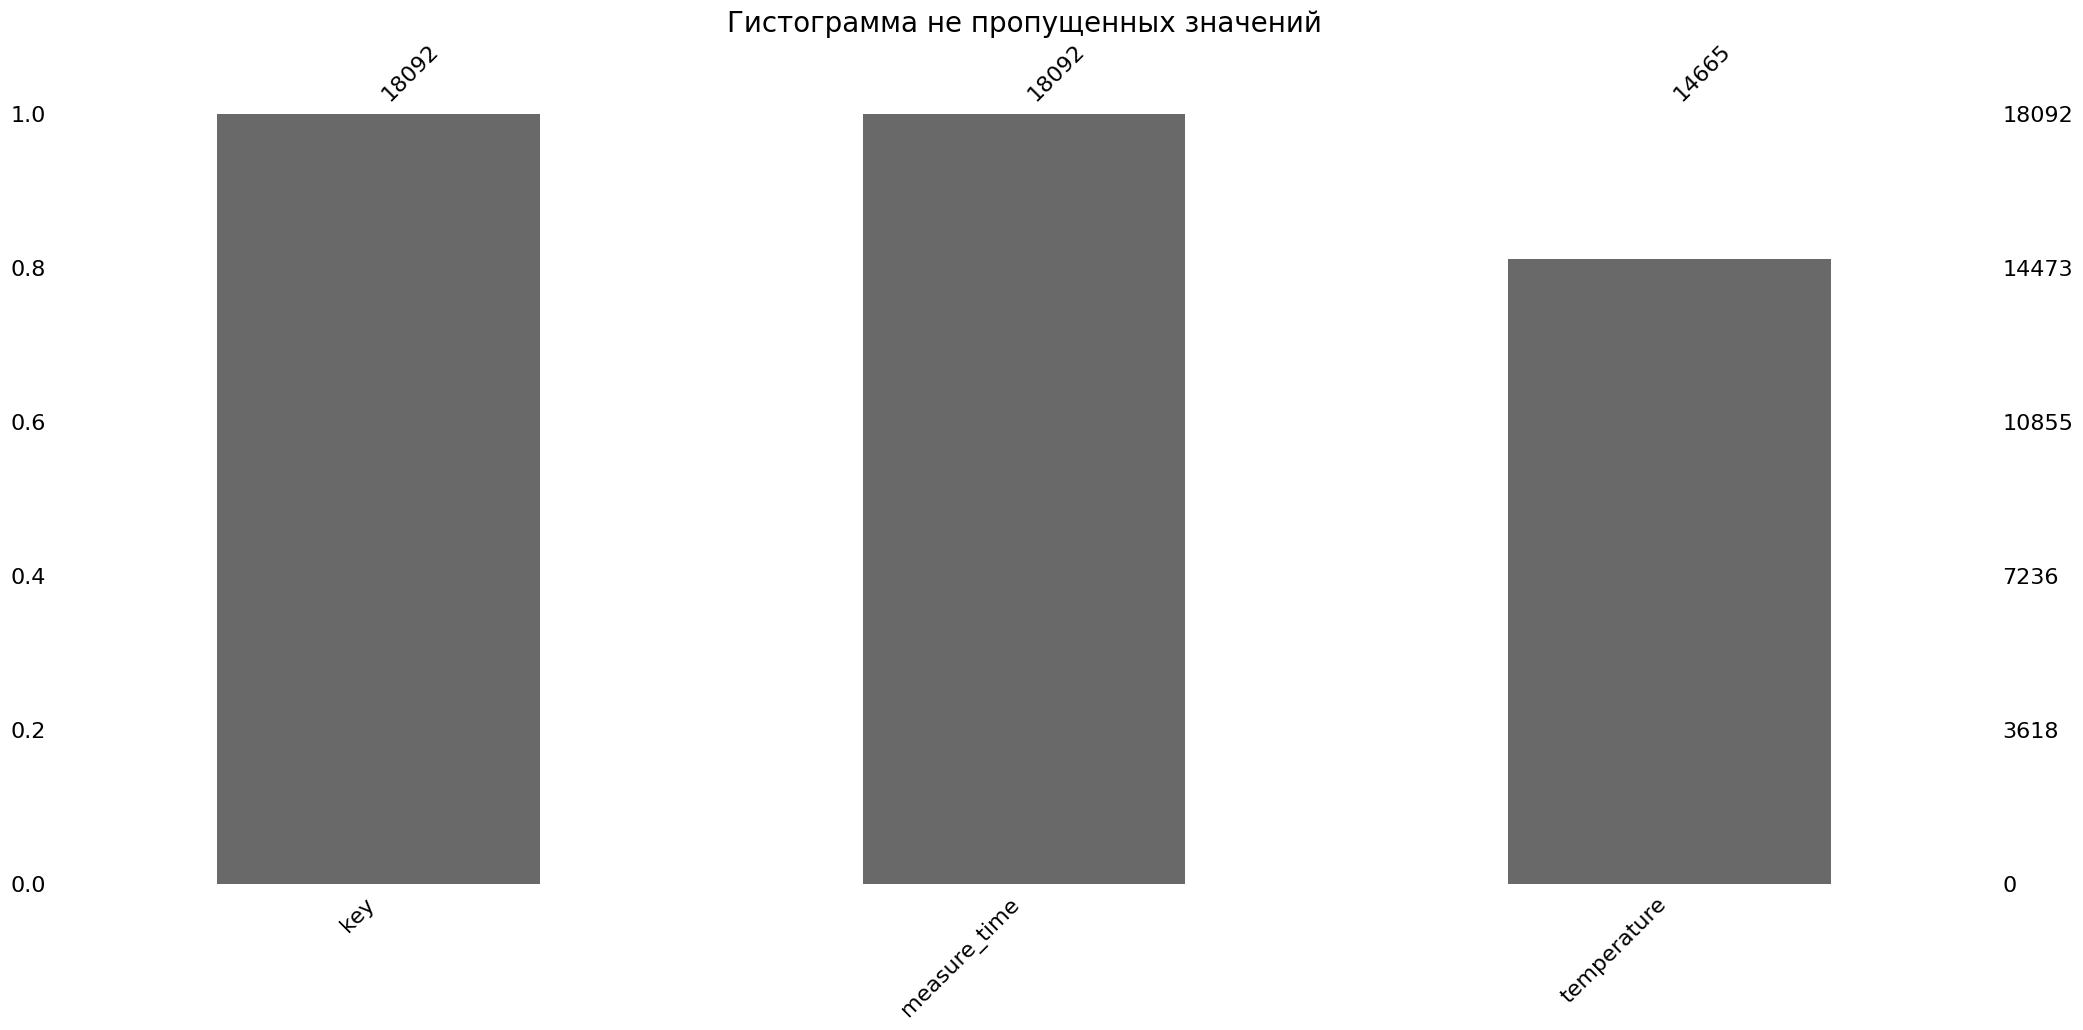

In [18]:
details(data_temp)

**Имеются пропуски в значениях температуры**

#### data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Явных дубликатов: 0
Количество партий: 3081


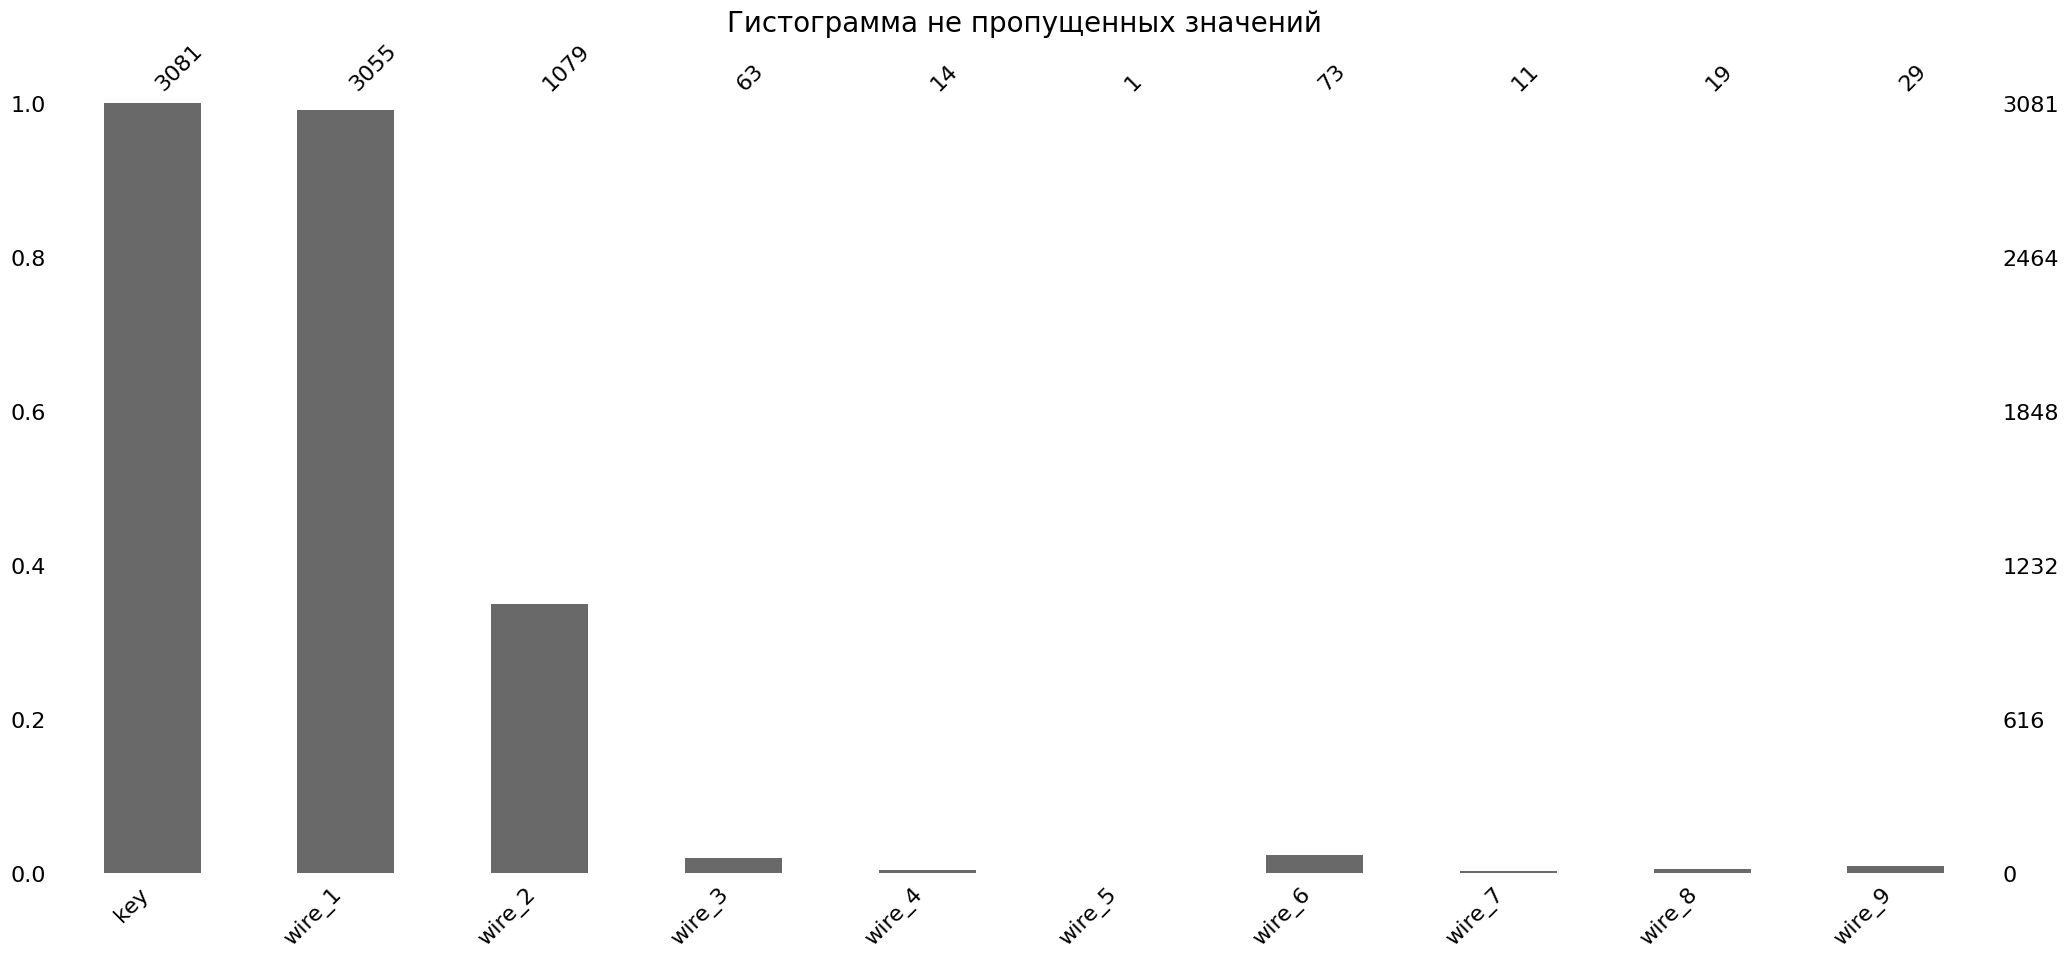

In [19]:
details(data_wire)

**В датасете о проволочных материалах так же как и в датасете о сыпучих материалах много пропусков, чаще других используются материалы wire_1 и wire_2**

#### data_wire_time

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Явных дубликатов: 0
Количество партий: 3081


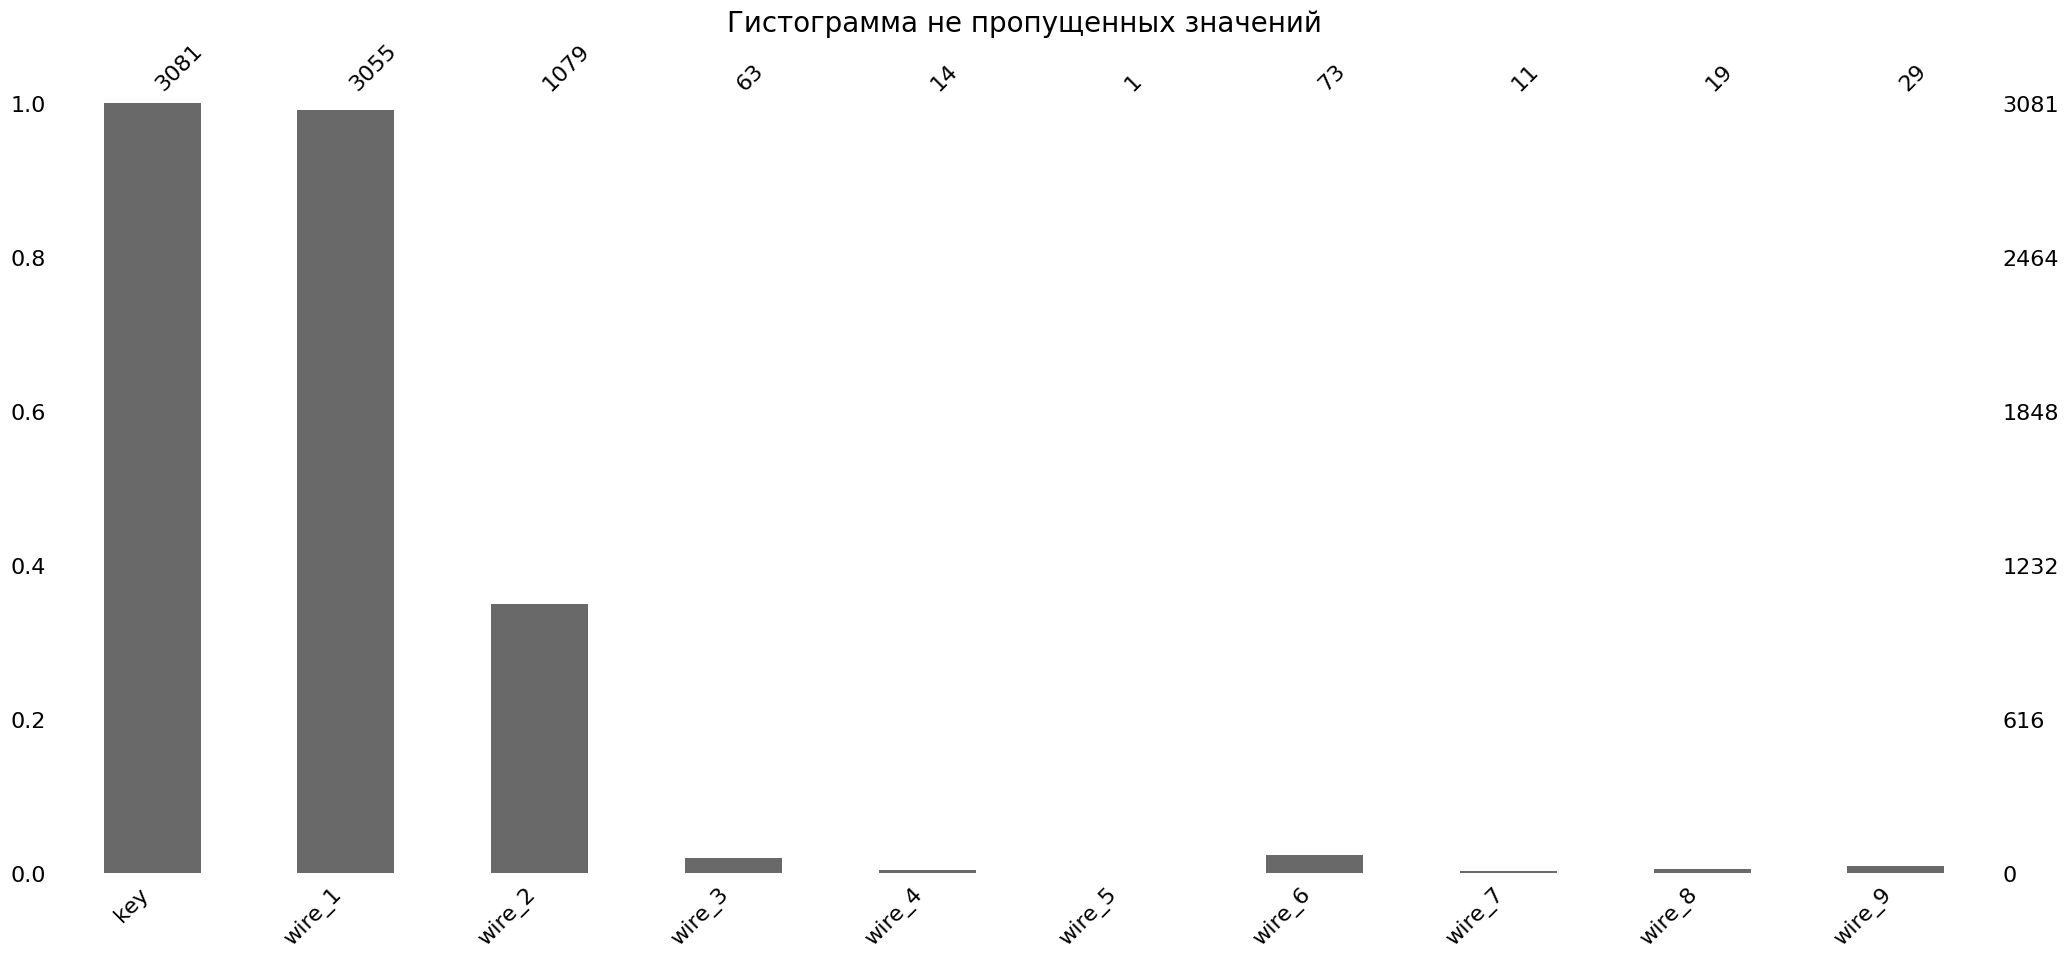

In [20]:
details(data_wire_time)

**Аналогично датасету с количеством проволоки**

**На основании предварительного осмотра данных можно сделать следующие выводы:**
* В данных об объеме и времени подачи сыпучих/проволочных материалов много пропусков, так как от партии к партии состав сплава отличается
* В датасетах разное количество уникальных keys, то есть партий, связано это с особенностью сбора промышленных данных - не всегда есть возможность сделать это в полной мере
* Временные типы данных при загрузке были приведены к корректному datetime 

## Исследовательский анализ и предобработка данных

**Для начала посмотрим на срез данных по одной партии, например с key = 3**

In [21]:
example = 3

for df in data_names_dict:
    display(data_names_dict[df].query('key == @example'))

,key,heat_start,heat_end,active_p,reactive_p
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856
10,3,2019-05-03 12:13:52,2019-05-03 12:15:56,0.542675,0.474673
11,3,2019-05-03 12:18:56,2019-05-03 12:20:45,0.774632,0.505690
12,3,2019-05-03 12:25:43,2019-05-03 12:27:00,1.222963,0.863676
13,3,2019-05-03 12:31:14,2019-05-03 12:32:19,0.421693,0.272562


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16


,key,gas_1
2,3,28.554793


,key,measure_time,temperature
11,3,2019-05-03 12:06:44,1596.0
12,3,2019-05-03 12:13:42,1597.0
13,3,2019-05-03 12:18:46,1598.0
14,3,2019-05-03 12:25:33,1599.0
15,3,2019-05-03 12:31:04,1600.0
16,3,2019-05-03 12:35:57,1599.0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**По этому срезу видно, что для одной партии возможно добавление и сыпучих материалов и добавление проволоки одновременно, так же только 4-мя сыпучими из 15, и одним из 9 проволочным материалом был легирован сплав, остальные материалы не задействованы**

**Теперь рассмотрим датасеты на предмет выбросов, построим для каждого количественного признака построим гистограмму и боксплот**

In [22]:
def feature_hist_box(df):
    numeric_columns = df.loc[:, ~df.columns.isin(['key'])].select_dtypes(include=['number']).columns
    for col in numeric_columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
        fig.suptitle(f'Анализ признака: {col}', fontsize=16)
        sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color='royalblue')
        axes[0].set_title(f'Распределение {col}')
        axes[0].set_xlabel('')
        axes[0].set_ylabel('Частота')
        sns.boxplot(x=df[col], ax=axes[1], color='orange')
        axes[1].set_title(f'Боксплот {col}')
        axes[1].set_xlabel('')
        plt.show()  

### data_arc

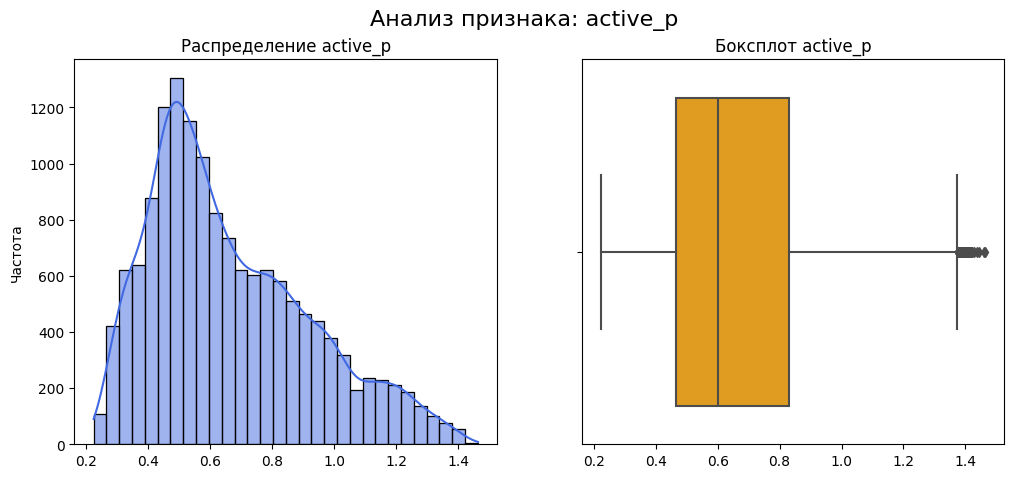

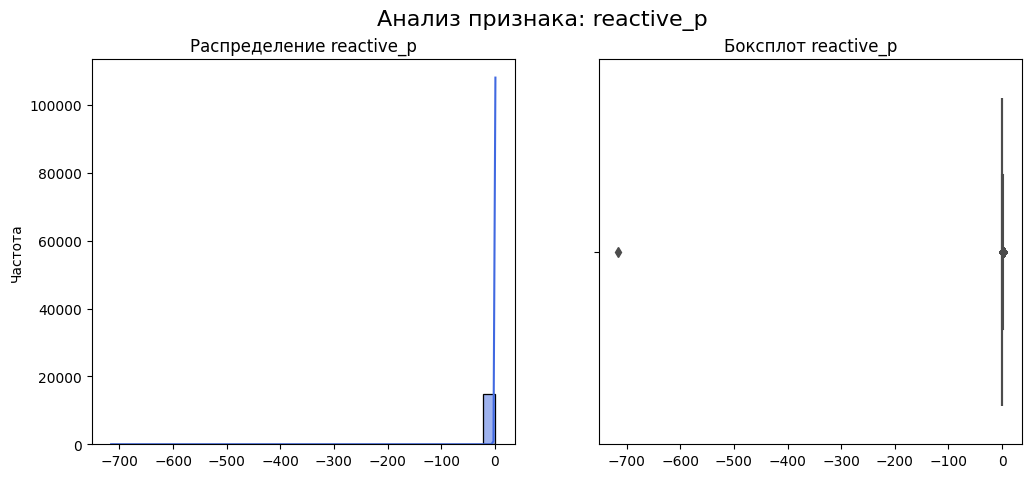

In [23]:
feature_hist_box(data_arc)

**Если с активной мощностью все хорошо, то с реактивной в области отрицательных значений присутствует очевидный выброс, удалим его**

In [24]:
data_arc[data_arc['reactive_p'] < 0]

,key,heat_start,heat_end,active_p,reactive_p
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


**Возьмем коэффициент мощности на всех этапах в данной партии 2116, усредним его и вычислим замену**

In [25]:
data_arc.query('key==2116')

,key,heat_start,heat_end,active_p,reactive_p
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [26]:
reactive_p_2116 = data_arc.query('key==2116')['reactive_p'].values
active_p_2116 = data_arc.query('key==2116')['active_p'].values
cos_phi_2116 = active_p_2116 / np.sqrt(reactive_p_2116**2 + active_p_2116**2)
print('Коэффициенты мощности:', cos_phi_2116[[0, 1, 3]])
replace_reactive = np.sqrt((active_p_2116[2] / ((cos_phi_2116[1] + cos_phi_2116[0] + cos_phi_2116[3]) / 3) ** 2) - (active_p_2116[2] ** 2))
replace_reactive

Коэффициенты мощности: [0.75031749 0.81570717 0.80969695]


0.791978848791665

In [27]:
data_arc.loc[(data_arc['key'] == 2116) & (data_arc['reactive_p'] < 0), 'reactive_p'] = replace_reactive

In [28]:
data_arc[data_arc['reactive_p'] < 0]

,key,heat_start,heat_end,active_p,reactive_p


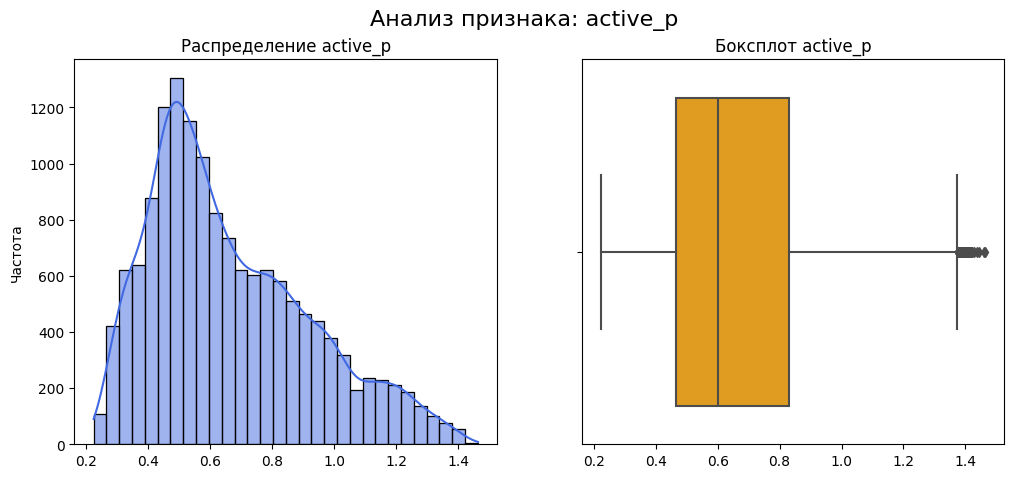

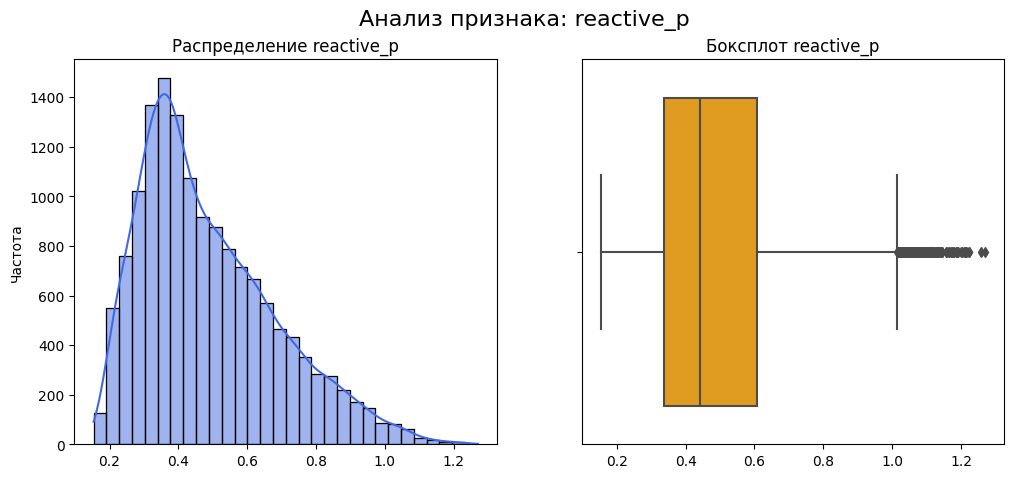

In [29]:
feature_hist_box(data_arc)

**Реактивная и активная мощность имеют распределение похожее на пауссоновское с пиками в ~0.5 относительных единиц мощности для активной и ~ 0.35 для реактивной. По критерию межквартильного размаха присутствуют выбросы, однако согласно рекомендациям мы не будем их исключать, так как такое вполне может быть и в реальном технологическом процессе**

**Добавим признаки объединяющие активную и реактивную мощности, а именно коэффициент мощности и полную мщность. Так же выделим временные промежутки этапов технолгического процесса в секундах, их мы затем умножим на коэффициент мощности. Так мы получим составной признак который характеризует какую часть из времени нагрева мы эффективно использовали энергию на поднятие температуры сплава**

<img src="https://i.imgur.com/nBO7Ku7.png" width="300">

In [30]:
data_arc = data_arc.copy()
data_arc.loc[:, 'full_p'] = (data_arc['reactive_p']**2 + data_arc['active_p']**2) ** (0.5)
data_arc.loc[:, 'cos_phi'] = data_arc['active_p'] / (data_arc['reactive_p']**2 + data_arc['active_p']**2) ** (0.5)
data_arc.loc[:, 'delta_sec'] = (data_arc['heat_end'] - data_arc['heat_start']).dt.seconds.astype('int')
data_arc.loc[:, 'effective_t'] =  data_arc['cos_phi'] * data_arc['delta_sec']

In [31]:
data_arc.head()

,key,heat_start,heat_end,active_p,reactive_p,full_p,cos_phi,delta_sec,effective_t
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,0.822181,228,187.457188
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,0.848545,185,156.980803
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,0.803161,172,138.143660
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,0.806591,365,294.405882
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,0.802950,148,118.836584


In [32]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          14876 non-null  int64         
 1   heat_start   14876 non-null  datetime64[ns]
 2   heat_end     14876 non-null  datetime64[ns]
 3   active_p     14876 non-null  float64       
 4   reactive_p   14876 non-null  float64       
 5   full_p       14876 non-null  float64       
 6   cos_phi      14876 non-null  float64       
 7   delta_sec    14876 non-null  int32         
 8   effective_t  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int32(1), int64(1)
memory usage: 988.0 KB


**Сгруппируем данные по партиям и просуммируем работы и мощности на каждом этапе, получив полные затраты энергии на электроды за время всей плавки и добавим в сводную таблицу среднее за партию значение коэффициента мощности**

In [33]:
data_arc_sum = data_arc.drop(['heat_start', 'heat_end'], axis=1).groupby(
    'key').agg('sum')[['delta_sec', 'effective_t', 'active_p', 'reactive_p', 'full_p']].reset_index()
data_arc_sum.loc[:, 'cos_phi_mean'] = data_arc.groupby('key').mean()['cos_phi'].values

In [34]:
data_arc_sum.head()

,key,delta_sec,effective_t,active_p,reactive_p,full_p,cos_phi_mean
0,1,1098,895.824117,3.036730,2.142821,3.718736,0.816686
1,2,811,661.322951,2.139408,1.453357,2.588349,0.825276
2,3,655,526.620338,4.063641,2.937457,5.019223,0.809724
3,4,741,588.285410,2.706489,2.056992,3.400038,0.793923
4,5,869,697.167375,2.252950,1.687991,2.816980,0.796818


### data_bulk и data_bulk_time

**Для данных по количеству сыпучих материалов еще раз посмотрим на количества пропущенных значений, оценим какие материалы стоит оставить**

In [35]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


**Посмотрим на то, какой процент ненулевые количества материалов составляют от общего кол-ва партий**

In [36]:
((1 - data_bulk.isna().sum() / data_bulk.shape[0]) * 100).sort_values(ascending=False)

key        100.000000
bulk_14     89.677213
bulk_12     78.299776
bulk_15     71.844040
bulk_3      41.482902
bulk_4      32.406520
bulk_6      18.408437
bulk_1       8.053691
bulk_11      5.656759
bulk_10      5.624800
bulk_5       2.460850
bulk_7       0.798977
bulk_2       0.703100
bulk_9       0.607223
bulk_13      0.575264
bulk_8       0.031959
dtype: float64

**Больше 10% ненулевых значений составляют материалы 14, 12, 15, 3, 4, 6 оставим их, пропуски заполним нулями, прочие материалы удалим**

In [37]:
to_keep = (((1 - data_bulk.isna().sum() / data_bulk.shape[0]) * 100) >= 10).values

data_bulk = data_bulk.loc[:, to_keep].fillna(0)
data_bulk_time = data_bulk_time.loc[:, to_keep].fillna(0)

In [38]:
display(data_bulk.head())
display(data_bulk_time.head())

,key,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15
0,1,0.0,43.0,0.0,206.0,150.0,154.0
1,2,0.0,73.0,0.0,206.0,149.0,154.0
2,3,0.0,34.0,0.0,205.0,152.0,153.0
3,4,0.0,81.0,0.0,207.0,153.0,154.0
4,5,0.0,78.0,0.0,203.0,151.0,152.0


,key,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15
0,1,0,2019-05-03 11:28:48,0,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,2019-05-03 11:36:50,0,2019-05-03 11:53:30,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,2019-05-03 12:32:39,0,2019-05-03 12:27:13,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,2019-05-03 12:43:22,0,2019-05-03 12:58:00,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,2019-05-03 13:30:47,0,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47


### data_gas 

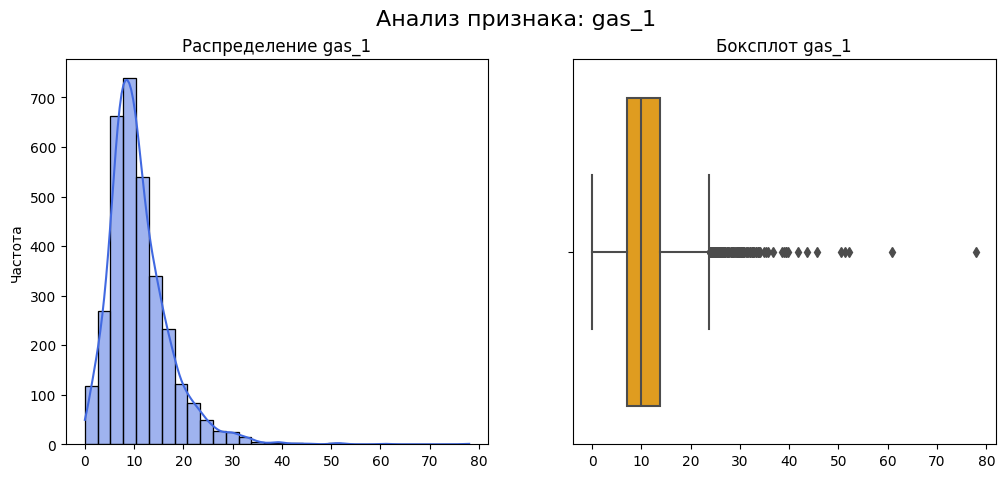

In [39]:
feature_hist_box(data_gas)

**Распределение имеет длинный хвост справа**

In [40]:
data_gas.sort_values(by='gas_1', ascending=False).head(20)

,key,gas_1
319,322,77.995040
277,280,60.935689
2107,2110,52.142373
2567,2570,51.380229
116,117,50.581035
2105,2108,45.638999
1461,1464,43.655411
660,663,41.854643
525,528,39.728826
610,613,39.425706


**Оставим все как есть, продувка инертным газом выравнивает температуру и химический состав сплава, ситуации , когда объем подаваемого газа будет сильно варьироваться, в производстве вполне возможны**

### data_temp

**Данный признак содержит целевой, для нас важно наличие начальной и конечной температуры(целевой признак) одновременно, только такие партии можно считать пригодными для использовании в задании**

**Пример объекта без целевого признака:**

In [41]:
data_temp.query('key==3239')

,key,measure_time,temperature
18071,3239,2019-09-06 14:16:50,1598.0
18072,3239,2019-09-06 14:22:49,NaN
18073,3239,2019-09-06 14:28:54,NaN
18074,3239,2019-09-06 14:33:34,NaN
18075,3239,2019-09-06 14:42:48,NaN
18076,3239,2019-09-06 14:56:58,NaN
18077,3239,2019-09-06 14:59:25,NaN
18078,3239,2019-09-06 15:03:35,NaN
18079,3239,2019-09-06 15:09:55,NaN


In [42]:
last_measurement_time = data_temp.groupby('key')['measure_time'].max()
data_temp[data_temp['measure_time'].isin(last_measurement_time)]['temperature'].isna().sum()

739

**Обнаружено 739 объектов не имеющих целевого признака, удалим их**

In [43]:
bad_keys = data_temp[
data_temp['measure_time'].isin(last_measurement_time) & data_temp['temperature'].isna()]['key'].unique()
bad_keys

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

In [44]:
data_temp = data_temp[~data_temp['key'].isin(bad_keys)]

**Посмотрим на количество замеров**

In [45]:
measurements_per_party = data_temp.groupby('key').size().sort_values()
bad_keys = list(measurements_per_party[measurements_per_party.values < 2].index)
bad_keys

[279, 195]

**195 и 279 партия не удовлетворяют условию, удалим их**

In [46]:
data_temp = data_temp[~data_temp['key'].isin(bad_keys)]

In [47]:
measurements_per_party = data_temp.groupby('key').size().sort_values()
print(measurements_per_party)

key
1169     2
977      2
1914     2
2112     2
1535     2
        ..
322     14
46      14
1513    16
1689    16
2108    17
Length: 2475, dtype: int64


**Сформируем таблицу в которой будет начальная и конечные температуры, отфильтруем температуры ниже 1300 , так как они не относятся к технологической температуре производства стали**

In [48]:
pivot_temp = pd.pivot_table(data_temp, values='temperature',
                                index='key', aggfunc = ['first', 'last']).reset_index()

pivot_temp.columns=['key', 'first_temperature', 'final_temperature']
pivot_temp = pivot_temp[(pivot_temp['first_temperature'] >= 1300) & (pivot_temp['final_temperature'] >= 1300)]
pivot_temp

,key,first_temperature,final_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


### data_wire и data_wire_time

**Анализ похож на анализ сыпучих материалов: посмотрим на количество пропусков и выкинем те проволочные материалы в которых пропущенно более 95% значений**

In [49]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [50]:
((1 - data_wire.isna().sum() / data_wire.shape[0]) * 100).sort_values(ascending=False)

key       100.000000
wire_1     99.156118
wire_2     35.021097
wire_6      2.369361
wire_3      2.044791
wire_9      0.941253
wire_8      0.616683
wire_4      0.454398
wire_7      0.357027
wire_5      0.032457
dtype: float64

**Так как только 2 из 9 признаков имеют пропусков меньше 95%, удалим остальные**

In [51]:
to_keep = (((1 - data_wire.isna().sum() / data_wire.shape[0]) * 100) >= 5).values

data_wire = data_wire.loc[:, to_keep].fillna(0)
data_wire_time = data_wire_time.loc[:, to_keep].fillna(0)

In [52]:
display(data_wire.head())
display(data_wire_time.head())

,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


,key,wire_1,wire_2
0,1,2019-05-03 11:06:19,0
1,2,2019-05-03 11:36:50,0
2,3,2019-05-03 12:11:46,0
3,4,2019-05-03 12:43:22,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34


**Итоги предварительного исследовательского анализа: большая часть сыпучих и проволочных легирующих материалов содержит большое кличество пропущенных значений, посмотрим в дальнейшем насколько информативными окажутся данные признаки. Был устранен выброс в реактивной мощности и добавлен признак характеризующий общие затраты энергии на протяжении всего тех. процесса. Удалены объекты без целевого признака**

## Объединение данных

**Будем объединять следующие наборы данных: pivot_temp с целевой и начальной температурами, data_arc_sum c полной затраченной энергией на нагрев электродами, data_gas с информацией о продуве инертным газом, data_bulk с количеством сыпучих материалов и data_wire с количеством проволочного материала**

In [53]:
df_main = (pivot_temp.merge(data_arc_sum, on='key', how='inner').
           merge(data_gas, on='key', how='inner').
           merge(data_bulk, on='key', how='inner').
           merge(data_wire, on='key', how='inner'))

In [54]:
print(df_main.shape)
df_main.head()

(2325, 18)


,key,first_temperature,final_temperature,delta_sec,effective_t,active_p,reactive_p,full_p,cos_phi_mean,gas_1,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,1571.0,1613.0,1098,895.824117,3.036730,2.142821,3.718736,0.816686,29.749986,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000
1,2,1581.0,1602.0,811,661.322951,2.139408,1.453357,2.588349,0.825276,12.555561,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000
2,3,1596.0,1599.0,655,526.620338,4.063641,2.937457,5.019223,0.809724,28.554793,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000
3,4,1601.0,1625.0,741,588.285410,2.706489,2.056992,3.400038,0.793923,18.841219,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000
4,5,1576.0,1602.0,869,697.167375,2.252950,1.687991,2.816980,0.796818,5.413692,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456


**Так же удалим столбец с номерами партий - после объединения он не представляет для нас ценности**

In [55]:
df_main = df_main.drop('key', axis=1)

In [56]:
df_main.isna().any()

first_temperature    False
final_temperature    False
delta_sec            False
effective_t          False
active_p             False
reactive_p           False
full_p               False
cos_phi_mean         False
gas_1                False
bulk_3               False
bulk_4               False
bulk_6               False
bulk_12              False
bulk_14              False
bulk_15              False
wire_1               False
wire_2               False
dtype: bool

**При объединении таблиц новых пропусков не возникло**

## Исследовательский анализ и предобработка данных объединённого датафрейма

**Визуализируем новые признаки**

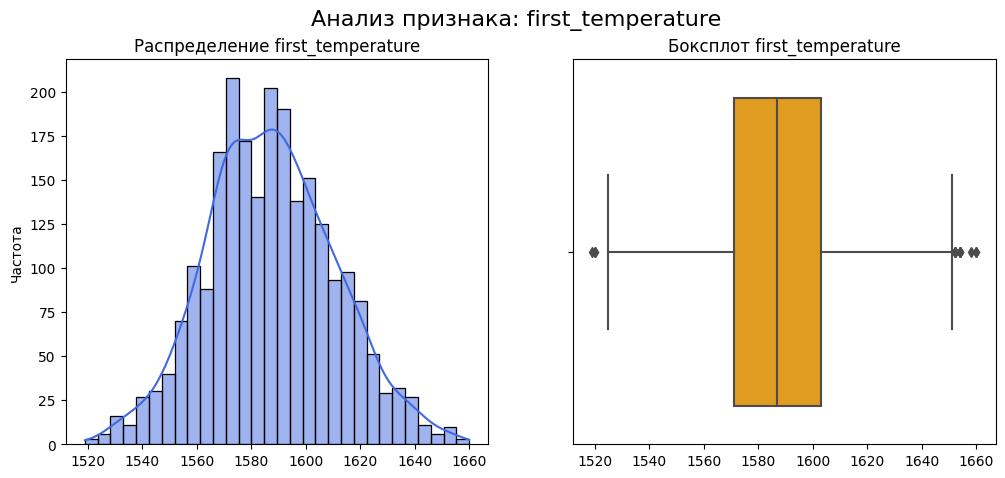

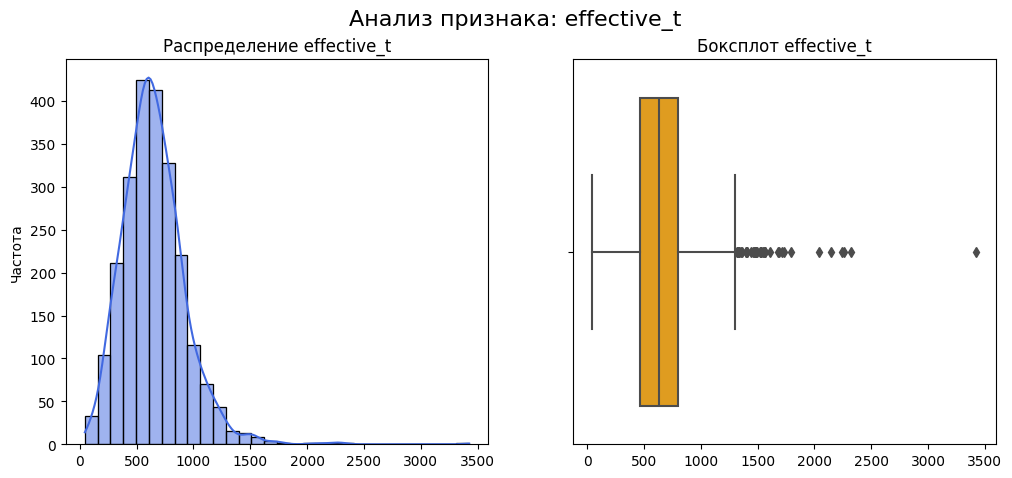

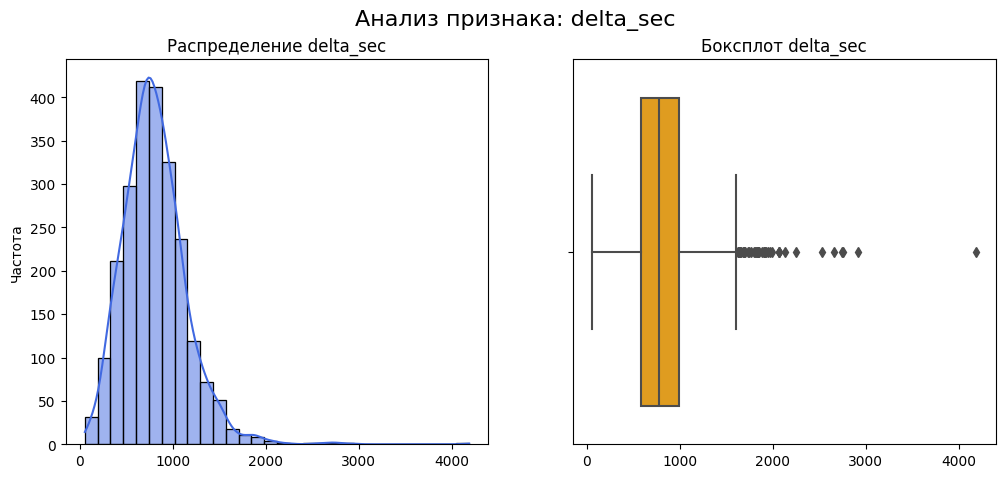

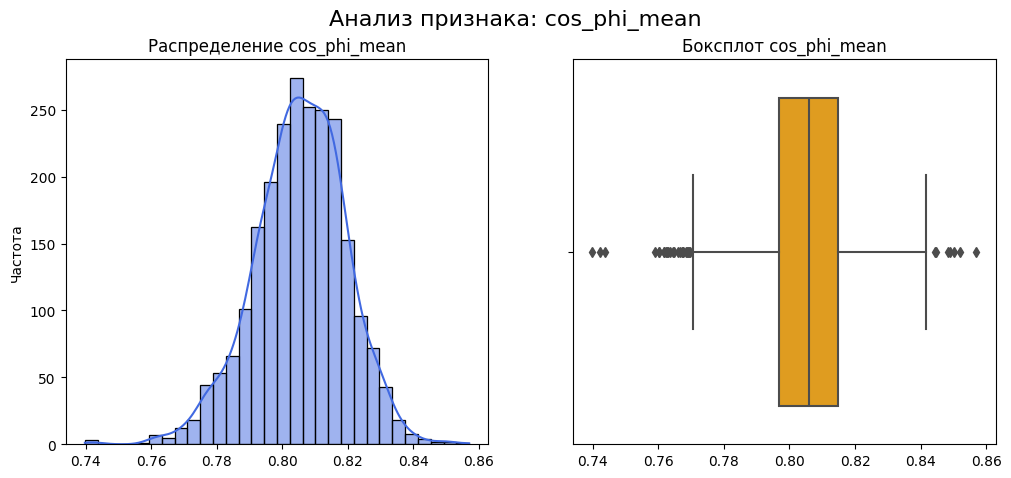

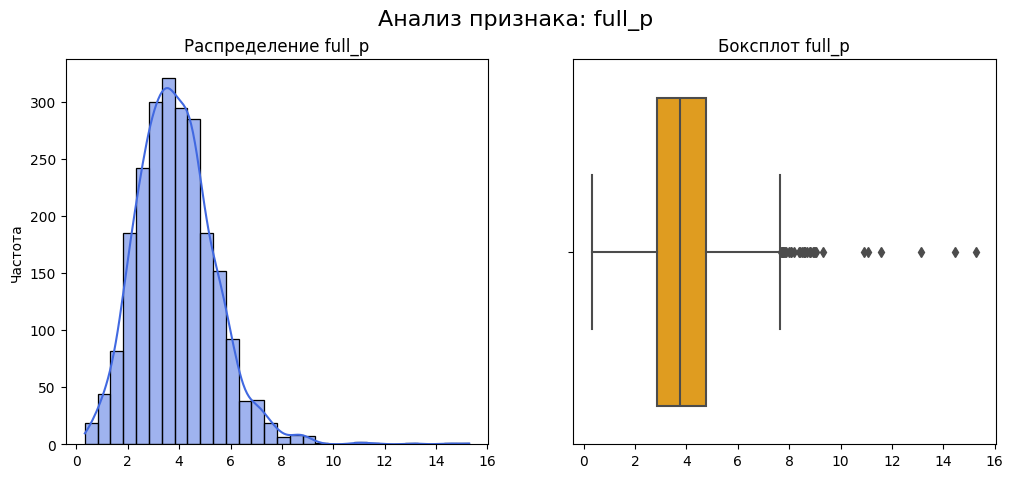

In [57]:
for col in ['first_temperature', 'effective_t', 'delta_sec', 'cos_phi_mean', 'full_p']:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
    fig.suptitle(f'Анализ признака: {col}', fontsize=16)
    sns.histplot(df_main[col], bins=30, kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title(f'Распределение {col}')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Частота')
    sns.boxplot(x=df_main[col], ax=axes[1], color='orange')
    axes[1].set_title(f'Боксплот {col}')
    axes[1].set_xlabel('')
    plt.show()  

**Признаки имеют небольшие хвосты, однако после того, как мы подчистим аномальные значения на учебной выборке они центрируются**

### Корреляционный анализ

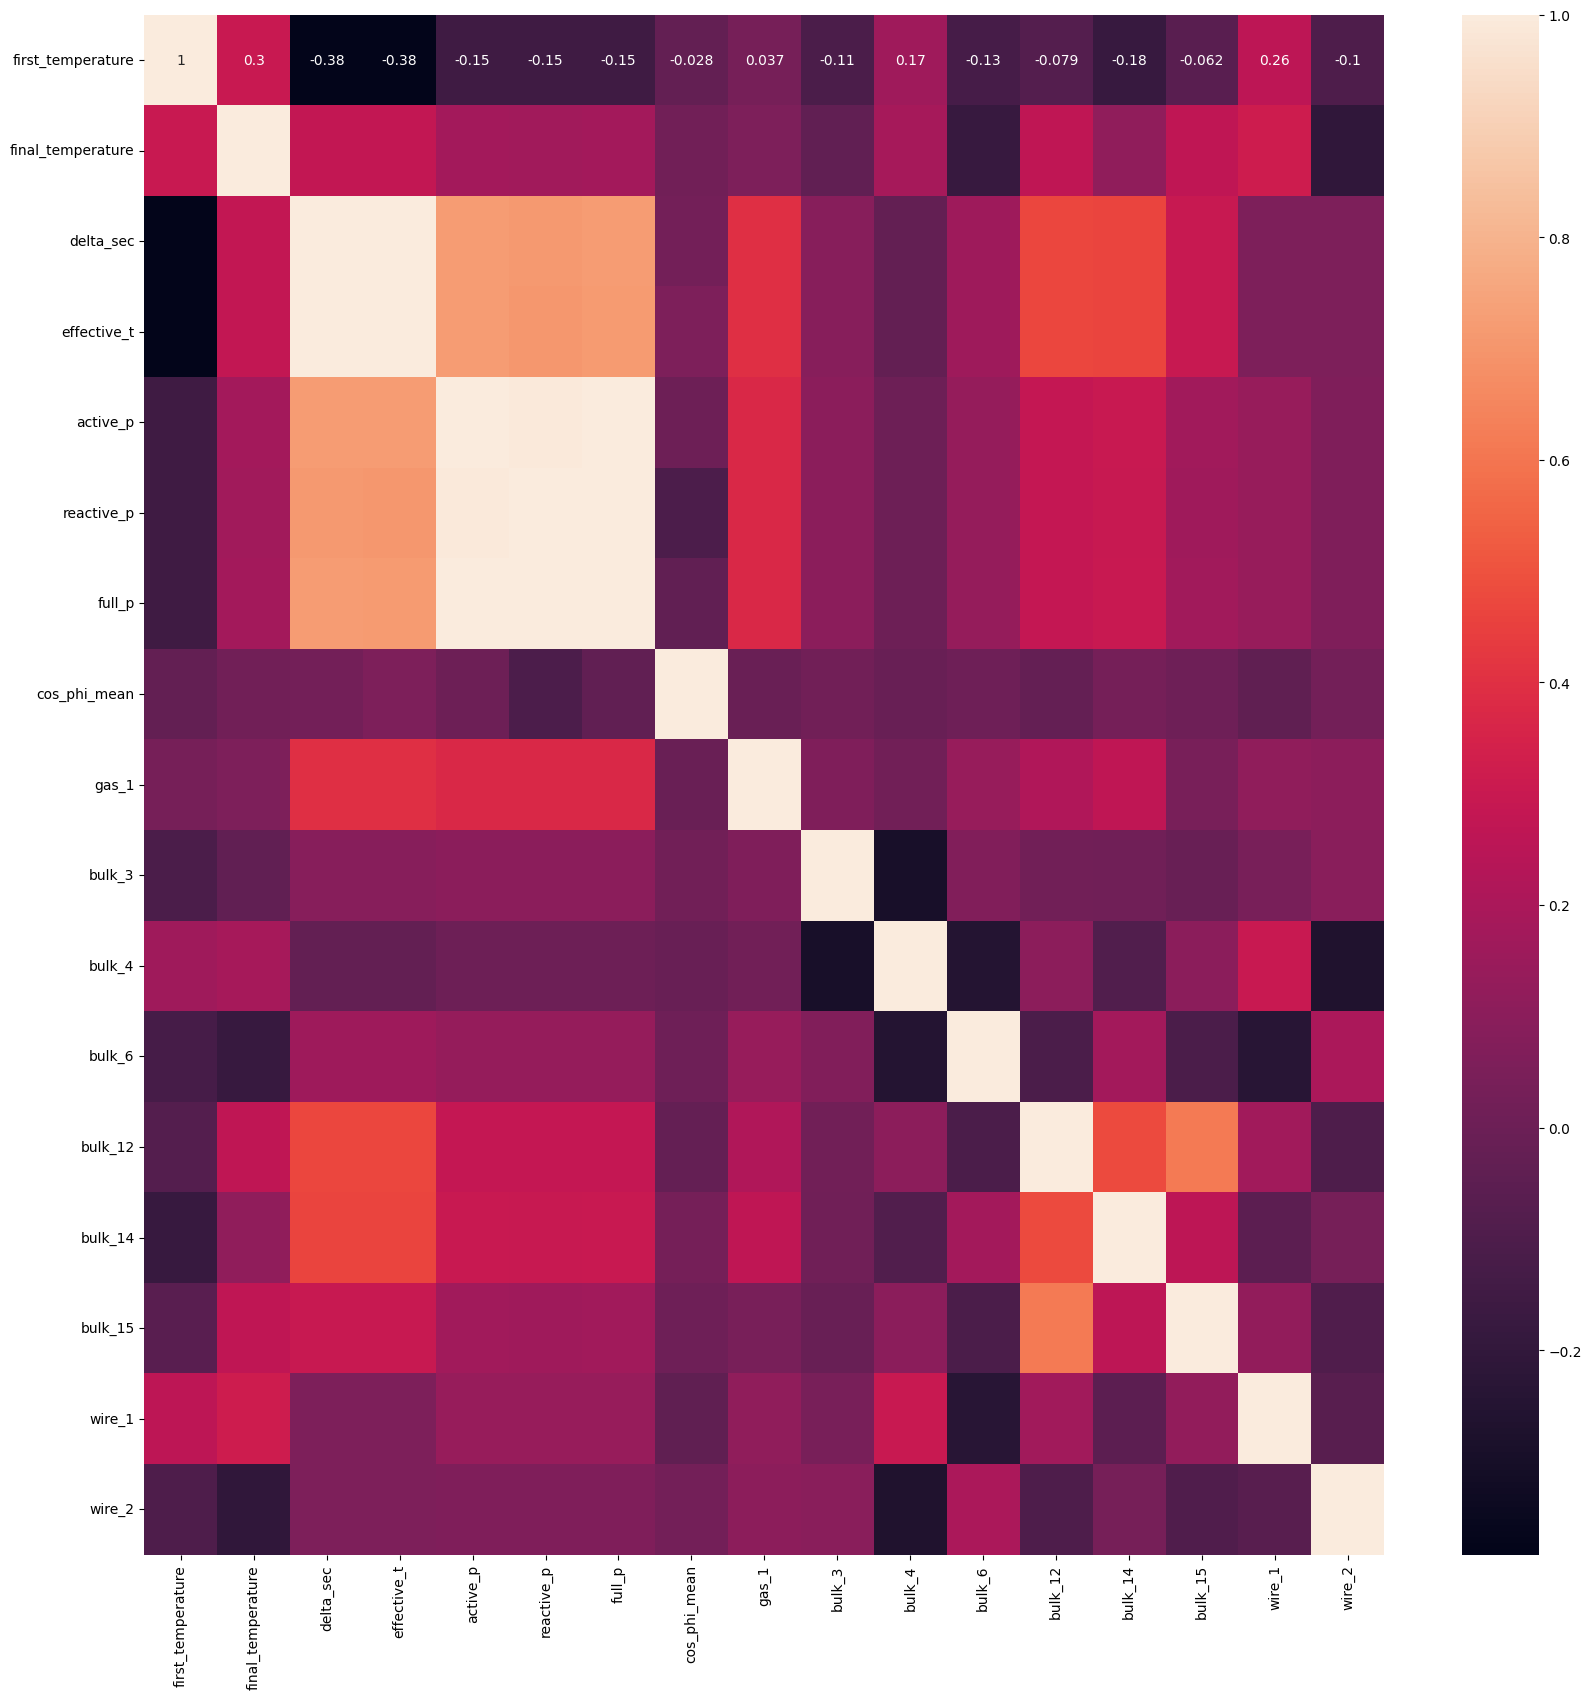

In [58]:
fig = plt.subplots(figsize=(20,20))
sns.heatmap(df_main.corr(), annot = True)
plt.show()

In [59]:
corr_df = df_main.corr()
corr_cols = corr_df.stack().index.to_list()
corr_dict = {}
for elem in corr_cols:
    if (elem[0] != elem[1]) & (elem[::-1] not in corr_dict.keys()):
        corr_dict[elem] = corr_df.loc[elem]
corr_pairs = pd.DataFrame(pd.Series(corr_dict).sort_values(ascending=False))
corr_pairs  

0
delta_sec         effective_t  0.999105
active_p          full_p       0.999024
reactive_p        full_p       0.996851
active_p          reactive_p   0.992381
delta_sec         active_p     0.720695
...                                 ...
bulk_4            bulk_6      -0.251889
                  wire_2      -0.267932
bulk_3            bulk_4      -0.295303
first_temperature effective_t -0.382785
                  delta_sec   -0.383660

[136 rows x 1 columns]

In [60]:
display(corr_pairs.head(10))
display(corr_pairs.tail(10))

,,0
delta_sec,effective_t,0.999105
active_p,full_p,0.999024
reactive_p,full_p,0.996851
active_p,reactive_p,0.992381
delta_sec,active_p,0.720695
effective_t,active_p,0.719358
delta_sec,full_p,0.719153
effective_t,full_p,0.716331
delta_sec,reactive_p,0.712788
effective_t,reactive_p,0.707305


0
first_temperature active_p    -0.153248
                  bulk_14     -0.180058
final_temperature bulk_6      -0.181880
                  wire_2      -0.206837
bulk_6            wire_1      -0.235764
bulk_4            bulk_6      -0.251889
                  wire_2      -0.267932
bulk_3            bulk_4      -0.295303
first_temperature effective_t -0.382785
                  delta_sec   -0.383660

**Сразу можно отметить мультиколлинеарность между признаками effective_t и delta_sec, так как одно получается из другого умножением, то это вполне логично. Для обучения возьмем только признак delta_t и full_power, как показавшие себя лучше при тестировании.**

In [61]:
corr_pairs.loc['final_temperature']

,0
wire_1,0.317702
effective_t,0.279539
delta_sec,0.278418
bulk_12,0.267379
bulk_15,0.266386
bulk_4,0.188100
active_p,0.176646
full_p,0.174903
reactive_p,0.171005
bulk_14,0.114520


**Сильные корреляции признаков с целевым не обнаружены, будем исходить из того, как признаки относятся друг к другу, очевидн что брать синтетические признаки на основе времени и мощности при мультиколлинеарности не имеет смысла**

## Подготовка данных

**Разделим данные на обучающую и тестовую выборки в соотншении 80/20:**

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    df_main.drop(['final_temperature','active_p', 'reactive_p', 'effective_t'], axis=1),
    df_main['final_temperature'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((1743, 13), (582, 13))

**Уберем аномалии с помощью KNN и изоляционного леса, сделаем это только на учебной выборке**

In [63]:
model_knn = KNN()
estimation_knn = model_knn.fit_predict(X_train)
outliers_knn = np.array(estimation_knn) == 1
print('Количество аномалий (KNN): ', sum(outliers_knn))

model_forest = IsolationForest(n_estimators=100, random_state=RANDOM_STATE)
estimation_iforest = model_forest.fit_predict(X_train)
outliers_iforest = np.array(estimation_iforest) == -1
print('Количество аномалий (изоляционный лес): ', sum(outliers_iforest))

Количество аномалий (KNN):  175
Количество аномалий (изоляционный лес):  144


**Уберем аномалии, которые выявили один или другой алгоритмы**

In [64]:
outliers_mask = outliers_knn | outliers_iforest
print(sum(outliers_mask))
X_train = X_train[~outliers_mask].reset_index(drop=True)
y_train = y_train[~outliers_mask].reset_index(drop=True)

238


**Начинаем создавать пайплайны, сперва для масштабирования, кодирование нам не понадобится, так как все признаки количественные**

In [65]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), X_train.columns)], 
    remainder='passthrough')

**Создаем итоговый пайплайн для каждой модели отдельно, чтобы исключить случайность при перебре моделей в RandomSearchCV**

In [66]:
pipe_final_GBRegressor = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

param_grid_GBRegressor = [
    # словарь для модели GradientBoostingRegressor
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [200, 500],  
        'models__learning_rate': [0.01, 0.03, 0.05], 
        'models__max_depth': [3, 6], 
        'models__min_samples_split': [2, 5],
        'models__min_samples_leaf': [1, 3],
        'models__subsample': [0.7, 0.9], 
        'preprocessor__num': ['passthrough']
    }]

In [67]:
pipe_final_DTreeRegressor = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid_DTreeRegressor = [
    # словарь для модели DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10, 15],  
        'models__min_samples_split': [2, 5, 10],  
        'models__min_samples_leaf': [1, 3, 5],  
        'models__max_features': ['sqrt', 'log2', None],
        'preprocessor__num': ['passthrough']
    }]

In [68]:
pipe_final_ElasticNet = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', ElasticNet())
])

param_grid_ElasticNet = [
    # словарь для модели ElasticNet
         {
        'models': [ElasticNet()],
        'models__alpha': [0.01, 0.1, 0.5, 1, 2],
        'models__l1_ratio': [0.1, 0.2, 0.35, 0.4, 0.5, 0.8, 1], 
        'preprocessor__num': ['passthrough']
     }]

In [69]:
pipe_final_XGBRegressor = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_XGBRegressor = [
    # словарь для модели XGBRegressor
    {
        'models': [XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)],
        'models__n_estimators': [200, 500],  
        'models__learning_rate': [0.01, 0.03, 0.05],  
        'models__max_depth': [3, 6],  
        'models__subsample': [0.7, 0.9],  
        'models__colsample_bytree': [0.5, 0.7, 1],
        'models__reg_lambda': [0, 1, 5, 10],
        'preprocessor__num': ['passthrough']
    }]

**Создаем словарь с моделями и гиперпараметрами для их перебора**

## Обучение моделей машинного обучения

**Напишем функцию, которая будет возвращать слварь с лучшей моделью, метрикой и параметрами после обучения, для того чтобы затем сложить результат обучения разных моделей в одну таблицу**

In [70]:
def train_randomized(X_train, y_train, pipe, param_grid, name):
    
    randomized_search = RandomizedSearchCV(
            pipe,
            param_grid,
            scoring='neg_mean_absolute_error',
            cv=5,
            n_iter=40,
            random_state=RANDOM_STATE,
            n_jobs=-1)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    mae = randomized_search.best_score_
    
    return {'Model': name,
            'Best Params': randomized_search.best_params_,
            'Mean CV MAE': abs(mae),
            'Best Model': best_model}

**Пример работы функции на ElasticNet:**

In [71]:
train_randomized(X_train, y_train, pipe_final_ElasticNet, param_grid_ElasticNet, 'ElasticNet')

C:\Users\datre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 35 is smaller than n_iter=40. Running 35 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'Model': 'ElasticNet',
 'Best Params': {'preprocessor__num': 'passthrough',
  'models__l1_ratio': 0.1,
  'models__alpha': 0.01,
  'models': ElasticNet()},
 'Mean CV MAE': 6.008859116836236,
 'Best Model': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num', 'passthrough',
                                                   Index(['first_temperature', 'delta_sec', 'full_p', 'cos_phi_mean', 'gas_1',
        'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1',
        'wire_2'],
       dtype='object'))])),
                 ('models', ElasticNet(alpha=0.01, l1_ratio=0.1))])}

In [72]:
results_train = []
results_train.append(train_randomized(X_train, y_train, pipe_final_GBRegressor, param_grid_GBRegressor, 'GradientBoostingRegressor'))
results_train.append(train_randomized(X_train, y_train, pipe_final_DTreeRegressor, param_grid_DTreeRegressor, 'DecisionTreeRegressor'))
results_train.append(train_randomized(X_train, y_train, pipe_final_ElasticNet, param_grid_ElasticNet, 'ElasticNet'))
results_train.append(train_randomized(X_train, y_train, pipe_final_XGBRegressor, param_grid_XGBRegressor, 'XGBRegressor'))

results_df = pd.DataFrame(results_train)

C:\Users\datre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 35 is smaller than n_iter=40. Running 35 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [73]:
pd.set_option('display.max_colwidth', 400)
results_df.sort_values(by='Mean CV MAE')

,Model,Best Params,Mean CV MAE,Best Model
3,XGBRegressor,"{'preprocessor__num': 'passthrough', 'models__subsample': 0.7, 'models__reg_lambda': 1, 'models__n_estimators': 500, 'models__max_depth': 3, 'models__learning_rate': 0.03, 'models__colsample_bytree': 1, 'models': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping...",5.802540,"(ColumnTransformer(remainder='passthrough',\n transformers=[('num', 'passthrough',\n Index(['first_temperature', 'delta_sec', 'full_p', 'cos_phi_mean', 'gas_1',\n 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1',\n 'wire_2'],\n dtype='object'))]), XGBRegressor(base_score=None, booster=None, callbacks=None,..."
0,GradientBoostingRegressor,"{'preprocessor__num': 'passthrough', 'models__subsample': 0.7, 'models__n_estimators': 500, 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_depth': 6, 'models__learning_rate': 0.01, 'models': GradientBoostingRegressor(random_state=100325)}",5.831664,"(ColumnTransformer(remainder='passthrough',\n transformers=[('num', 'passthrough',\n Index(['first_temperature', 'delta_sec', 'full_p', 'cos_phi_mean', 'gas_1',\n 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1',\n 'wire_2'],\n dtype='object'))]), ([DecisionTreeRegressor(criterion='friedman_mse', max_depth..."
2,ElasticNet,"{'preprocessor__num': 'passthrough', 'models__l1_ratio': 0.1, 'models__alpha': 0.01, 'models': ElasticNet()}",6.008859,"(ColumnTransformer(remainder='passthrough',\n transformers=[('num', 'passthrough',\n Index(['first_temperature', 'delta_sec', 'full_p', 'cos_phi_mean', 'gas_1',\n 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1',\n 'wire_2'],\n dtype='object'))]), ElasticNet(alpha=0.01, l1_ratio=0.1))"
1,DecisionTreeRegressor,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 2, 'models__min_samples_leaf': 5, 'models__max_features': None, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=100325)}",6.805684,"(ColumnTransformer(remainder='passthrough',\n transformers=[('num', 'passthrough',\n Index(['first_temperature', 'delta_sec', 'full_p', 'cos_phi_mean', 'gas_1',\n 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1',\n 'wire_2'],\n dtype='object'))]), DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, rand..."


## Выбор лучшей модели

**Лучше всего себя показала модель XGBRegressor без масштабирования данных, ее и возьмем для тестирования**

In [74]:
best_model = XGBRegressor(subsample=0.7, reg_lambda=1, n_estimators=500,
                                       max_depth=3, learning_rate=0.03, colsample_bytree=1, random_state=RANDOM_STATE)

In [75]:
best_model.fit(X_train, y_train)
y_preds = best_model.predict(X_test)
test_score = mean_absolute_error(y_test, y_preds)
print('Метрика MAE на тестовых данных: ', round(test_score, 4))

Метрика MAE на тестовых данных:  6.1358


**Метрика MAE < 6.5 - удовлетворяет техническому заданию**

**Так же добавим проверку на адекватность - сравним нашу лучшую модель с результами dummy модели, которая будет иметь константные предсказания равные среднему значению и медиане целевого признака**

In [76]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)
mean_preds = dummy_mean.predict(X_test)

dummy_median = DummyRegressor(strategy='median')
dummy_median.fit(X_train, y_train)
median_preds = dummy_median.predict(X_test)

In [77]:
print('MAE дамми модели с средним значением:', mean_absolute_error(y_test, mean_preds))
print('MAE дамми модели с медианой:', mean_absolute_error(y_test, median_preds))
print('MAE лучшей модели:', mean_absolute_error(y_test, y_preds))

MAE дамми модели с средним значением: 7.715033508008813
MAE дамми модели с медианой: 7.702749140893471
MAE лучшей модели: 6.135837200990657


**Как мы видим наша модель показывает результат лучше, чем дамми модели**

## Общий вывод и рекомендации заказчику

**Прежде чем делать итоговый вывод для наглядности рассмотрим важность признаков при предсказании, для этого воспользуемся коэффициентами Шепли**

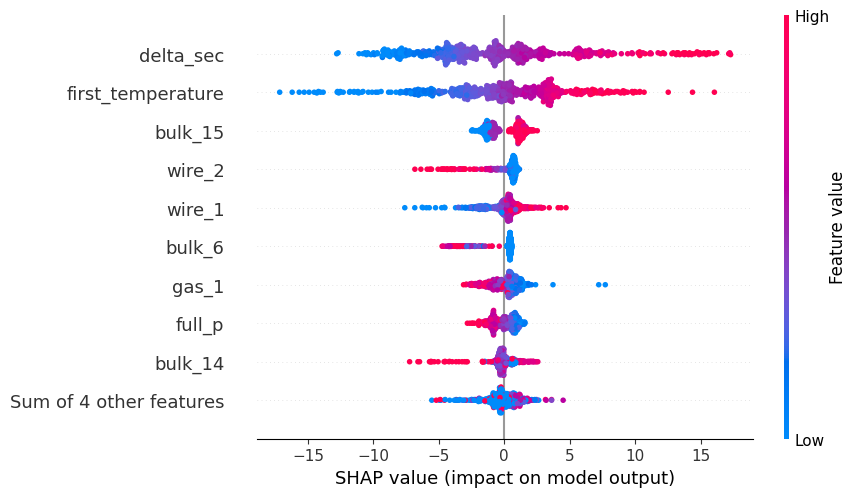

In [78]:
explainer = shap.TreeExplainer(best_model, X_test)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

**По этой диаграмме мы видим следующее:**
* Начальная температура очевидно прямо влияет на конечную, скачкообразно ничего не меняется
* Чем больше идет технический процесс тем выше конечная температура и наоборот - там где нагрев подавался недолго температура меньше
* Добавление bulk_15, bulk_4 и wire_1 повышают конечную температуру при увеличении подачи материалов и уменьшают ее согласно модели, если не былм использованы
* Добавление bulk_6 и wire_2 а так же продувка газом наоборот - уменьшает конечную температуру сплава при увеличении интенсивности подачи/продувки и увеличивают, если не были добавлены в тех. процесс(или имеют низкое значение)

**Расмотрим на примере случайной партии:**

In [79]:
print('final_temperature:', y_test.iloc[42])
display(X_test.iloc[42])

final_temperature: 1620.0


first_temperature    1593.000000
delta_sec            1653.000000
full_p                  5.283477
cos_phi_mean            0.817253
gas_1                  41.854643
bulk_3                100.000000
bulk_4                127.000000
bulk_6                  0.000000
bulk_12               413.000000
bulk_14               299.000000
bulk_15               204.000000
wire_1                130.244400
wire_2                  0.000000
Name: 614, dtype: float64

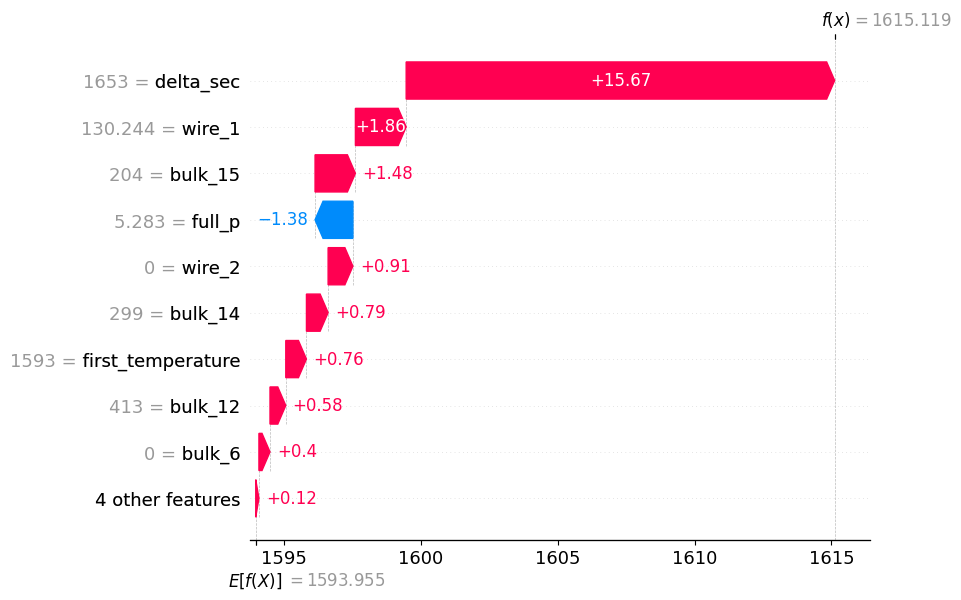

In [80]:
shap.plots.waterfall(shap_values[42])

**Тут видно, что нагрев шел недолго, поэтому модель занизила предсказание, bulk_15 не был добавлен - еще минус к конечной температуре, bulk_6 тоже не был добавлен - но он уже увеличил этим температуру, bulk_4 и продувка небольшим количеством газа увеличили предсказание**

**Итоговый вывод:**

**Цель проекта: на основе производственных данных разработать модель для задачи регрессии определения конечной температуры сплава после всех этапов обработки материала**

**Исходные данные представляют из себя семь датасетов с произвдственными параметрами различных партий сплавов. В ходе работы были проделаны следующие шаги:**

1. Во время загрузки выполнено следующее:
    * Данные приведены к нужному формату, например к datetime 
    * Отредактированы названия столбцов с признаками
   
   
     В ходе предварительного осмотра данных выделено:     
     
     * В данных об объеме и времени подачи сыпучих/проволочных материалов много пропусков, так как от партии к партии состав сплава отличается
     * В датасетах разное количество уникальных keys, то есть партий, связано это с особенностью сбора промышленных данных - не всегда есть возможность сделать это в полной мере
 
 
2. Затем был произведен исследвательский анализ каждого набора данных в отдельности и последующая обработка:
    * Удален выброс в данных по электродам
    * Добавили признаки объединяющие активную и реактивную мощности, а именно коэффициент мощности и полную мщность. Так же выделили временные промежутки этапов технолгического процесса в секундах
    * Удалены малоинформативные столбцы с сыпучими и проволочными материалами с большим количеством пропусков
    * Удалены объекты без целевого признака(конечной температуры сплава)
    
    
3. Затем данные были объединены по номеру партии


4. Объединенные данные были визуализированны и проверены на аномалии с помощью изоляционного леса и KNN, удалены не подходящие значения


5. В ходе подготовки данных к обучению модели:

    * Данные разбиты на обучающую и тестовую выборки в отношении 80/20
    * Подготовлен пайплайн перебора моделей и гиперпараметров
    
    
6. Затем была выбрана лучшая модель с помощью случайного поиска по сетке RandomizedSearchCV с метрикой качества MAE


7. Лучше всего себя показала модель GradientBoostingRegressor без масштабирования данных, ее МАЕ = 6.136 градуса на тестовой выборке


8. Визуализирована важность признаков при предсказании с помощью shap, сделаны следующие выводы:

    * Чем больше идет технический процесс тем выше конечная температура и наоборот - там где нагрев подавался недолго температура меньше
    * Добавление bulk_15, bulk_4 и wire_1 повышают конечную температуру при увеличении подачи материалов и уменьшают ее согласно модели, если не былм использованы
    * Добавление bulk_6 и wire_2 а так же продувка газом наоборот - уменьшает конечную температуру сплава при увеличении интенсивности подачи/продувки и увеличивают, если не были добавлены в тех. процесс(или имеют низкое значение)
    
**На основе данных наблюдений могу порекомендовать заказчику предварительно разогревать сталь до более высокой температуры и компенсировать короткую длительность процесса нужными добавками(например bulk_15) которые при повышении концентрации повышают температуру конечного сплава**